In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

In [81]:
file_path = 'w1w2w3w4w5_indices_weights_jul12_2022.csv'
df = pd.read_csv(file_path, low_memory=False)

file_path2 = 'w6_cleaned_weights_june12_2023.csv'
w6_df = pd.read_csv(file_path2, low_memory=False)

combined_df = pd.concat([df, w6_df], ignore_index=True)

mapping_cc2 = {4:0,
               2:1,
               3:2,
               1:3}

mapping_cc4_wealthUS = {1:1,
                         2:2,
                         99:3,
                         3:4,
                         4:5}

mapping_cc4_poorUS = {1:1,
                      2:2,
                      99:3,
                      3:4,
                      4:5}

mapping_cc4_comm = {1:1,
                    2:2,
                    99:3,
                    3:4,
                    4:5}

combined_df['cc2'] = combined_df['cc2'].replace(mapping_cc2)
combined_df['cc4_wealthUS'] = combined_df['cc4_wealthUS'].replace(mapping_cc4_wealthUS)
combined_df['cc4_poorUS'] = combined_df['cc4_poorUS'].replace(mapping_cc4_poorUS)
combined_df['cc4_comm'] = combined_df['cc4_comm'].replace(mapping_cc4_comm)

In [82]:
attitudesCC = ['cc2', 'cc6', 'cc_behavior_meat', 'cc_behavior_travel', 'cc_policy_cars', 'cc_policy_re', 'cc_policy_house', 'cc_policy_risk', 'cc4_wealthUS', 
                  'cc4_poorUS', 'cc4_comm']

supportCV = ['cv_behavior_crowds', 'cv_behavior_mask', 'cv_behavior_store', 'cv_behavior_activ', 'cv_behavior_discuss', 
            'cv_policy_vax',  'cv_policy_mask', 'cv_policy_hosp']

ew3 = ['ew3_phy', 'ew3_mat', 'ew3_fin',  'ew3_men']

trust = ['pol_trust_pres', 'pol_trust_cong', 'pol_trust_state', 'pol_trust_local', 'pol_trust_fema', 'pol_trust_bus', 'pol_trust_sci']

selected_columns = attitudesCC + supportCV + ew3 + trust

In [83]:
# Filter data for WAVE 5 and WAVE 6
w5 = combined_df[combined_df['WAVE'] == 5]
w6 = combined_df[combined_df['WAVE'] == 6]

# Store PID separately before scaling
w5_pids = w5[['PID']]  # Keep only the PID column
w6_pids = w6[['PID']]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale selected columns while keeping PID intact
w5_st = pd.DataFrame(scaler.fit_transform(w5[selected_columns]), columns=selected_columns)
w6_st = pd.DataFrame(scaler.fit_transform(w6[selected_columns]), columns=selected_columns)

# Add back PID and WAVE columns
w5_st['PID'] = w5_pids.values  # Ensure correct order
w6_st['PID'] = w6_pids.values
w5_st['WAVE'] = 5
w6_st['WAVE'] = 6

# Combine both standardized DataFrames
w5w6_st = pd.concat([w5_st, w6_st], ignore_index=True)

# Display result
print(w5w6_st.head())


        cc2       cc6  cc_behavior_meat  cc_behavior_travel  cc_policy_cars  \
0  0.666667  0.666667              0.00                0.00        0.500000   
1  0.666667  0.666667              0.75                0.75        0.666667   
2  0.000000  0.000000              0.00                0.00        0.000000   
3  1.000000  0.666667              1.00                1.00        0.666667   
4  0.666667  0.666667              0.50                0.50        0.666667   

   cc_policy_re  cc_policy_house  cc_policy_risk  cc4_wealthUS  cc4_poorUS  \
0      0.500000         0.500000        0.500000          0.00        0.00   
1      0.500000         0.666667        0.833333          0.75        1.00   
2      0.000000         0.000000        0.000000          0.00        0.00   
3      0.666667         0.666667        0.666667          0.25        0.25   
4      0.666667         0.666667        0.500000          0.25        1.00   

   ...   ew3_men  pol_trust_pres  pol_trust_cong  pol_tr

In [84]:
# Extract PIDs from each wave
w5_pids = set(combined_df[combined_df['WAVE'] == 5]['PID'])
w6_pids = set(combined_df[combined_df['WAVE'] == 6]['PID'])


# Find intersection (common PIDs in both waves)
common_pids = w5_pids.intersection(w6_pids)

# Convert to list or DataFrame
common_pids = list(common_pids)  # If you need a list
common_pids_df = pd.DataFrame(common_pids, columns=['PID'])  # If you need a DataFrame

w5w6_st = w5w6_st[w5w6_st['PID'].isin(common_pids)]



In [85]:
wave_counts = combined_df['WAVE'].value_counts()

# Count waves
wave_counts_df = pd.DataFrame({'WAVE': wave_counts.index, 'Count': wave_counts.values})
wave_counts_df.loc['Total'] = ['Total', wave_counts.sum()]
print(wave_counts_df)


        WAVE  Count
0          2   5194
1          1   5059
2          4   4378
3          5   4061
4          6   3954
5          3   3777
Total  Total  26423


<font size="6">Exploratory Data Analysis</font>

<font size="4">Selected Variables for the concept *attitudes toward climate change*: </font>

**cc2** = Temperature rise is a part of global warming/climate change. Do you think rising temperatures are a result of human activities, a result of natural causes, or both?

**cc6** = How worried are you about current and future global warming/climate change?

**cc_behavior_meat** = "To what extent, if any, do you take the following actions in order to help address climate change? Avoid consuming high-emissions food products, like meat and dairy "

**cc_behavior_travel** = "To what extent, if any, do you take the following actions in order to help address climate change? Seek out travel alternatives to avoid high-emissions modes of transportation like driving or flying "

**cc_policy_cars** = "To what extent, if any, do you support or oppose the following government mandates or measures aimed at addressing the climate change or reducing its impacts? Phase out sales of gas and diesel vehicles over the next 10 years and transition to all electric vehicles "

**cc_policy_re** = "To what extent, if any, do you support or oppose the following government mandates or measures aimed at addressing the climate change or reducing its impacts? Installation of large-scale renewable energy generation facilities (like solar farms or wind farms) in your area "

**cc_policy_house** = "To what extent, if any, do you support or oppose the following government mandates or measures aimed at addressing the climate change or reducing its impacts? Limits on housing development in areas that will likely experience future extreme weather events (e.g. flooding or fire risk) "

**cc_policy_risk** = "To what extent, if any, do you support or oppose the following government mandates or measures aimed at addressing the climate change or reducing its impacts? Requirement of property risk assessments and disclosure of future extreme weather risk (e.g. flooding or fire risk) by home owners, landlords or developers. "

**cc4_wealthUS** = How much, if at all, do you think global warming/climate change is currently harming wealthy communities within the United States ?

**cc4_poorUS** = How much, if at all, do you think global warming/climate change is currently harming poor communities within the United States?

**cc4_comm** = How much, if at all, do you think global warming/climate change is currently harming your local community ?

In [87]:
def summarize_dataframe(df):
    summary = []
    for col in df.columns:
        n_values = df[col].notna().sum()
        summary.append({
            'CC_variable': col,
            'n_missing': df[col].isna().sum(),
            'n_values': n_values,
            'complete_rate': 1 - (df[col].isna().sum() / len(df)),
            'mean': df[col].mean(),
            'sd': df[col].std(),
            'p0': df[col].min(),
            'p25': df[col].quantile(0.25),
            'p50': df[col].median(),
            'p75': df[col].quantile(0.75),
            'p100': df[col].max(),
            })
    
    return pd.DataFrame(summary)

summarize_dataframe(w5w6_st[attitudesCC])

,CC_variable,n_missing,n_values,complete_rate,mean,sd,p0,p25,p50,p75,p100
0,cc2,0,3376,1.0,0.640699,0.272075,0.0,0.666667,0.666667,0.666667,1.0
1,cc6,0,3376,1.0,0.590541,0.338621,0.0,0.333333,0.666667,1.000000,1.0
2,cc_behavior_meat,0,3376,1.0,0.257405,0.293921,0.0,0.000000,0.250000,0.500000,1.0
3,cc_behavior_travel,0,3376,1.0,0.252962,0.288211,0.0,0.000000,0.250000,0.500000,1.0
4,cc_policy_cars,0,3376,1.0,0.398302,0.323421,0.0,0.000000,0.500000,0.666667,1.0
5,cc_policy_re,0,3376,1.0,0.596367,0.298189,0.0,0.500000,0.666667,0.833333,1.0
6,cc_policy_house,0,3376,1.0,0.616607,0.277369,0.0,0.500000,0.666667,0.833333,1.0
7,cc_policy_risk,0,3376,1.0,0.588369,0.279637,0.0,0.500000,0.666667,0.833333,1.0
8,cc4_wealthUS,0,3376,1.0,0.368780,0.343131,0.0,0.000000,0.250000,0.750000,1.0
9,cc4_poorUS,0,3376,1.0,0.575533,0.377757,0.0,0.250000,0.750000,1.000000,1.0


For the variables representing the concept of attitudes toward climate change there are no NaN values and there are 8015 rows in over wave 5 and 6.

The following histogram plots present the distribution of data for the variables reflecting attitudes toward climate change.

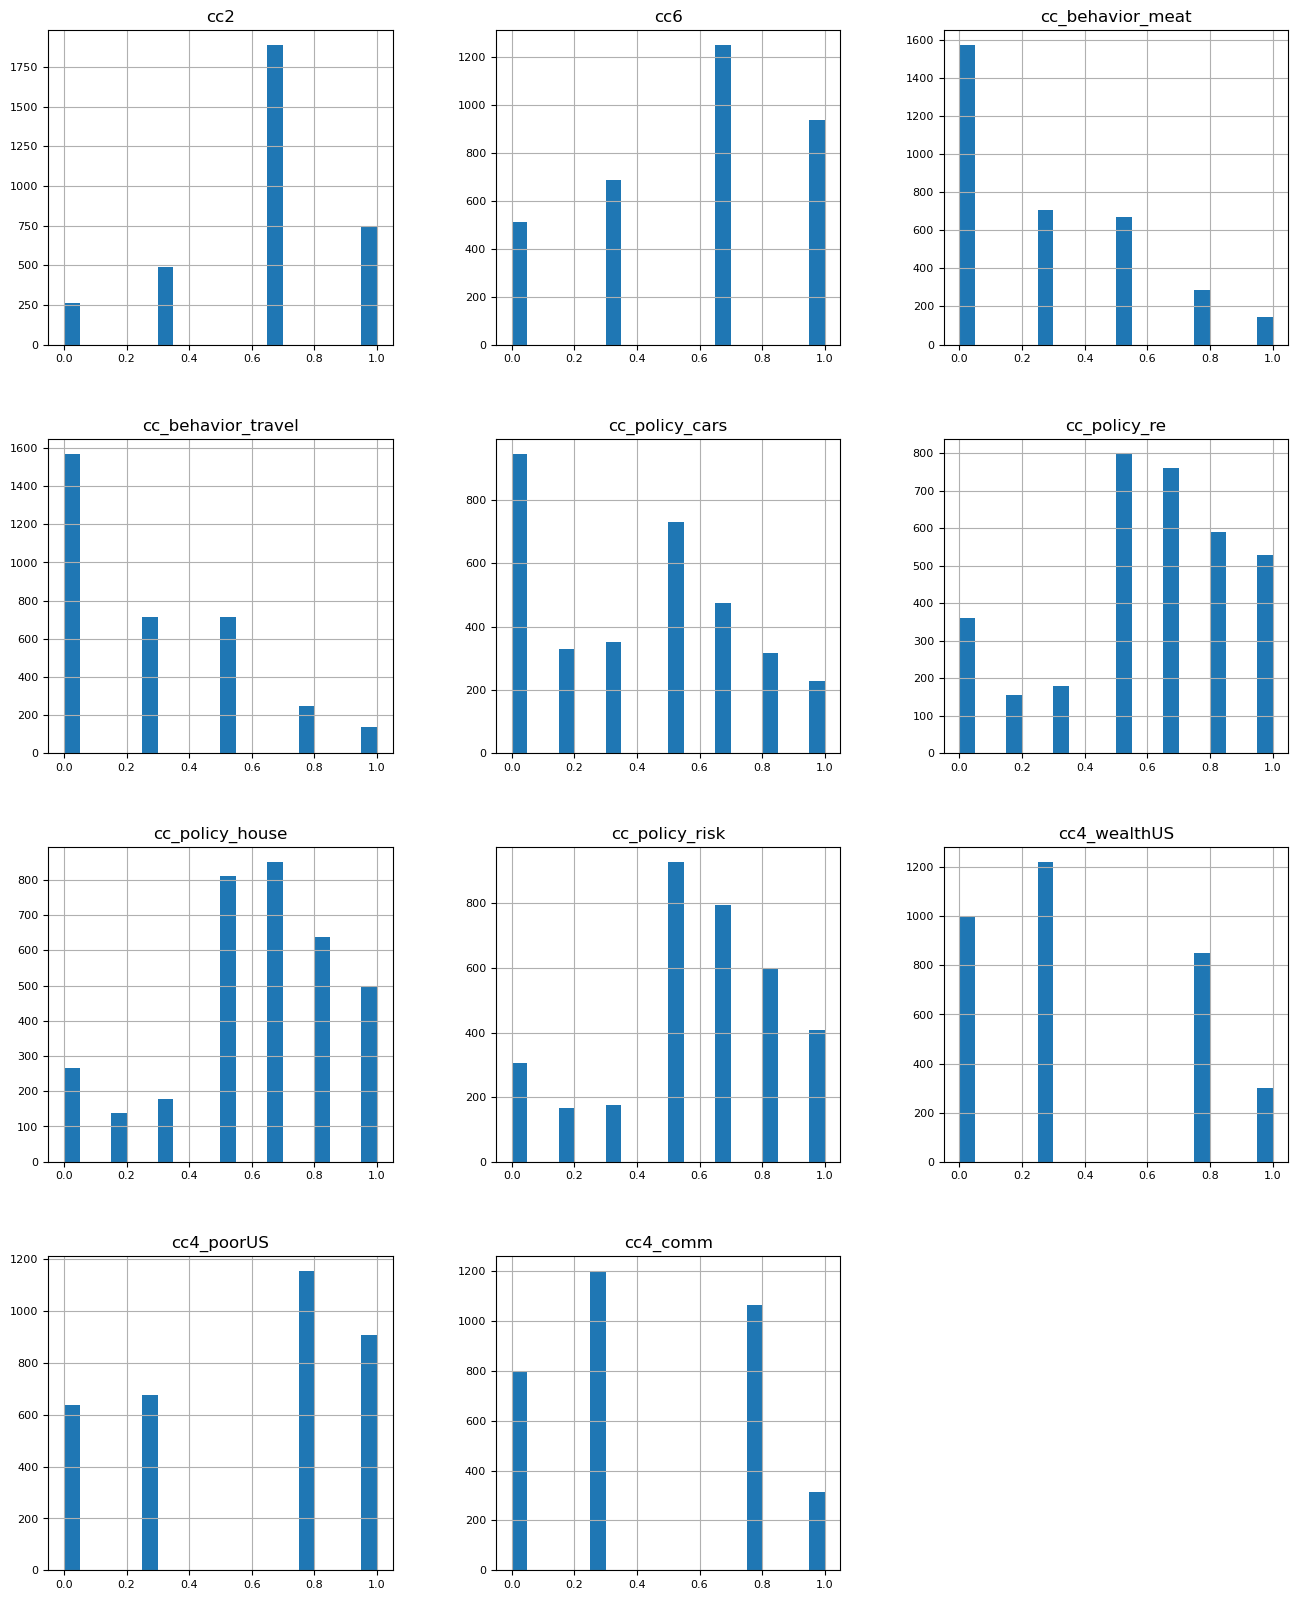

In [89]:
w5w6_st[attitudesCC].hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8);

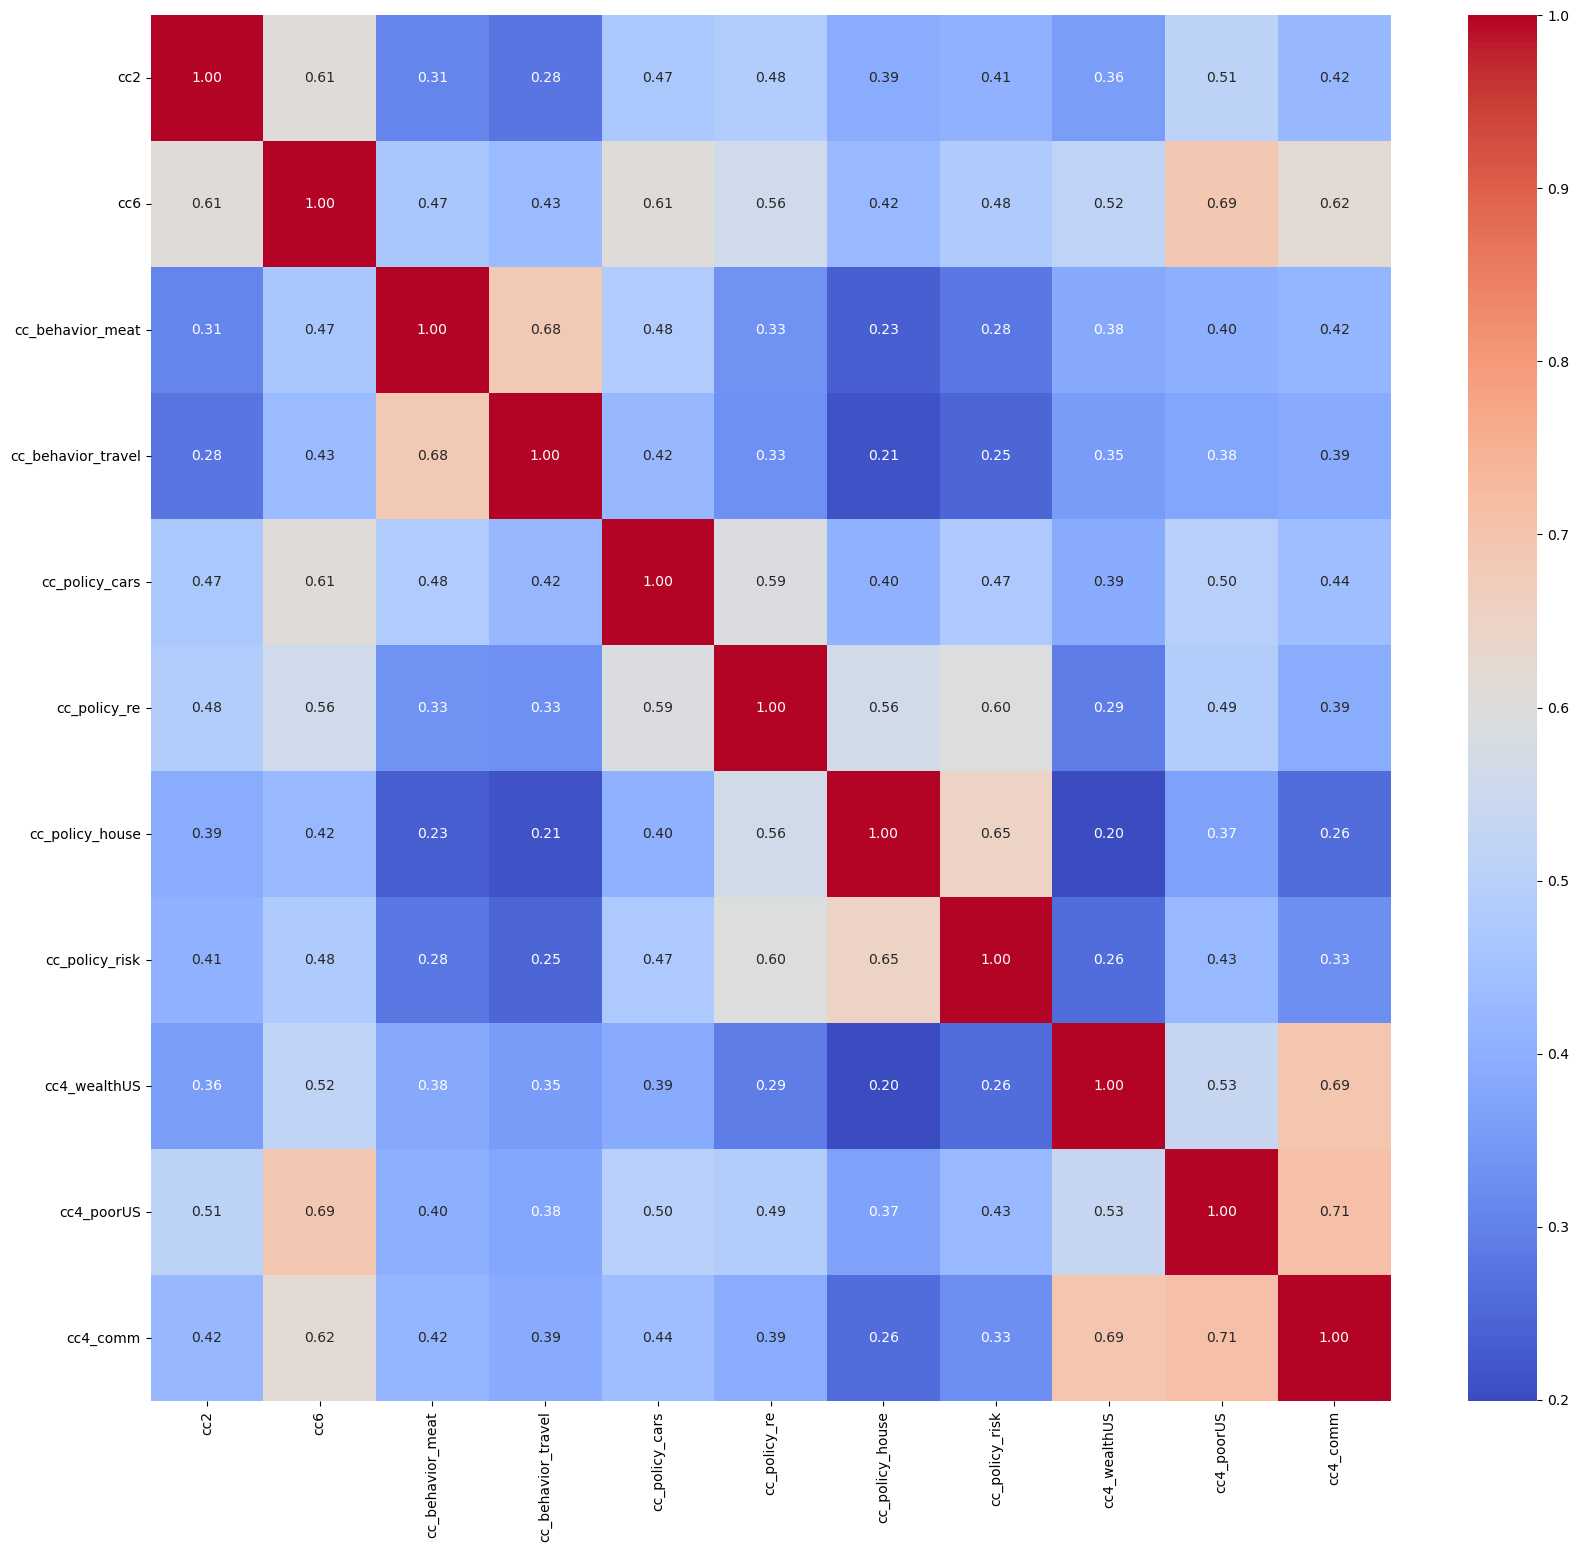

In [90]:
#Compute Spearman correlation
spearman_corr_CC = w5w6_st[attitudesCC].corr(method='spearman')

plt.figure(figsize=(20, 18)) 
sns.heatmap(
    spearman_corr_CC,
    annot=True,        
    fmt=".2f",           
    cmap='coolwarm',   
    cbar=True          
)
plt.show()

The variables cc_behavior_meat and cc_behavior_travel show a strong correlation. Additionally, variables related to climate policies (cc_policy_cars, cc_policy_re, cc_policy_house, cc_policy_risk) exhibit higher correlations, as do those concerning the impact of climate change on different groups of people (cc4_wealthUS, cc4_poorUS, cc4_comm). This alignment is expected, given their conceptual similarities.

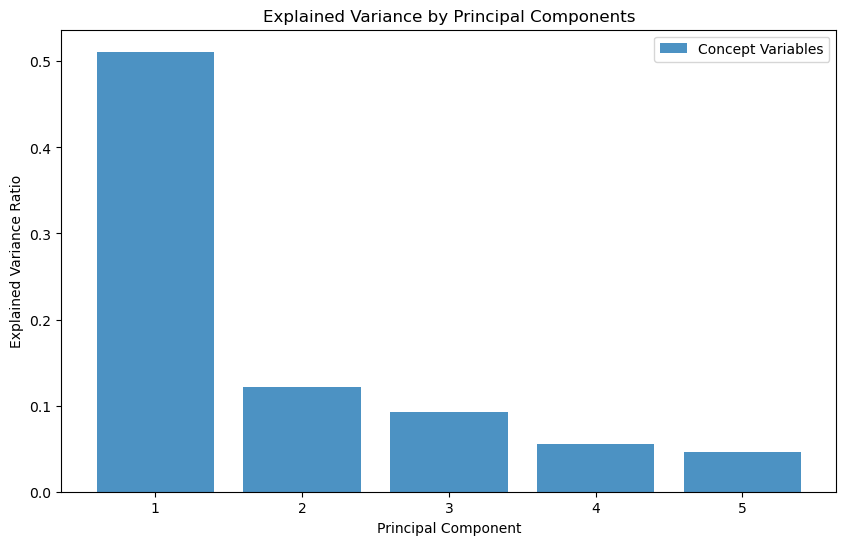

Explained Variance (Concept Variables - Attitudes toward Climate Change): [0.51115002 0.12108506 0.09235773 0.05521463 0.0466437 ]


In [92]:
pca_concepts = PCA(n_components=5)
pca_concepts.fit(w5w6_st[attitudesCC])

explained_variance_concepts = pca_concepts.explained_variance_ratio_

plt.figure(figsize=(10, 6))
# Concept Variables
plt.bar(range(1, len(explained_variance_concepts) + 1), explained_variance_concepts, alpha=0.8, label="Concept Variables")

plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.show()

print("Explained Variance (Concept Variables - Attitudes toward Climate Change):", explained_variance_concepts)

The Principal Component Analysis (PCA) reveals the proportion of variance explained by each principal component. The bar plot above shows that the first principal component accounts for 0.4717 of the variance, while the first three components collectively explain around 0.70 of the variance. To reduce dimensionality, it would be useful to examine the loadings of the first three principal components to understand what the variables contribute to the principal component.


In [96]:
# Get loadings
loadings = pd.DataFrame(
    pca_concepts.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_concepts.components_))],
    index=attitudesCC  # Original variable names as index
)
print(loadings)



                         PC1       PC2       PC3       PC4       PC5
cc2                 0.245164 -0.137741 -0.155468 -0.324612  0.099905
cc6                 0.391320 -0.036302 -0.088794 -0.325502  0.131183
cc_behavior_meat    0.233640  0.066025  0.628902 -0.028460 -0.149462
cc_behavior_travel  0.215025  0.077970  0.624024 -0.049961 -0.270231
cc_policy_cars      0.319365 -0.236009  0.199697  0.013124  0.725706
cc_policy_re        0.286236 -0.364277 -0.046035  0.121923  0.089681
cc_policy_house     0.217836 -0.411961 -0.110728  0.338587 -0.354860
cc_policy_risk      0.243071 -0.382444 -0.109718  0.328495 -0.263390
cc4_wealthUS        0.303568  0.502863 -0.095157  0.593793  0.220730
cc4_poorUS          0.424040  0.180708 -0.277762 -0.430984 -0.288931
cc4_comm            0.351448  0.423522 -0.174696  0.097181 -0.123493


The loadings indicate that cc4_poorUS, cc4_comm, cc6, cc4_wealthUS, and cc_policy_cars contribute the most (with values above 0.3) to the first principal component, which explains 0.4717 of the variance. For the second principal component, the main contributors are cc4_wealthUS, cc_policy_house, cc_policy_re, cc_policy_risk, and cc4_comm. Meanwhile, the third principal component is primarily influenced by cc_behavior_meat, cc_behavior_travel, and cc4_poorUS. When performing data reduction, it is important to consider these loadings to retain the most informative variables.

The plots below show the strength of the loadings per principal component. 

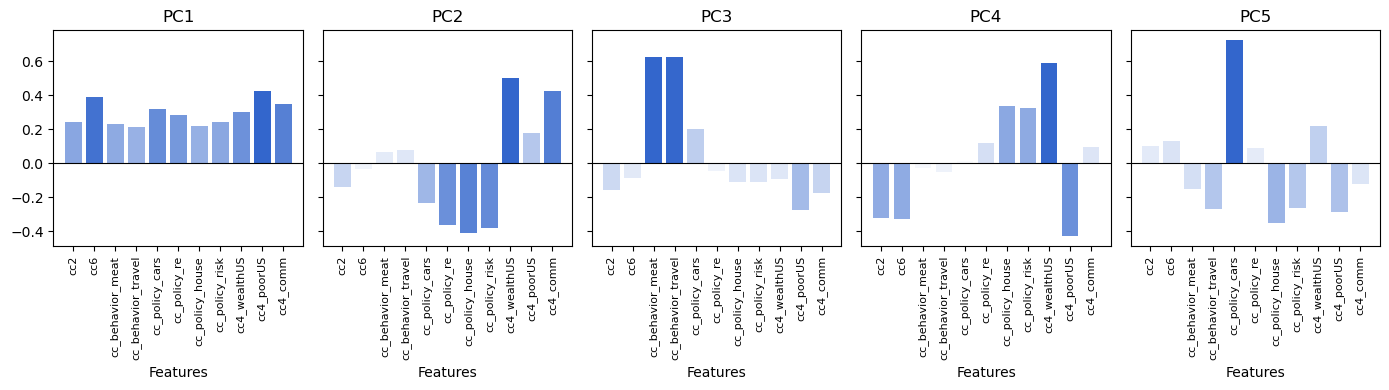

In [102]:
#A colormap function based on loading magnitude
def get_bar_colors(loadings):
    norm = np.abs(loadings) / np.max(np.abs(loadings)) 
    return [(0.2, 0.4, 0.8, alpha) for alpha in norm] 

# subplots
fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)

for i in range(5):
    ax = axes[i]
    pc_loadings = loadings[f'PC{i+1}']

    # color intensity
    colors = get_bar_colors(pc_loadings)

    #plot
    ax.bar(loadings.index, pc_loadings, color=colors)
    
    ax.axhline(0, color='black', linewidth=0.8)
    ax.xaxis.set_ticks(pc_loadings.index)
    ax.set_xticklabels(loadings.index, rotation=90, fontsize=8)
    ax.set_title(f"PC{i+1}")
    ax.set_xlabel("Features")
    
plt.tight_layout()
plt.show()


In [103]:
# Run Factor Analysis
fa = FactorAnalyzer(n_factors=6)
fa.fit(w5w6_st[attitudesCC])

# Get Factor Loadings
factor_loadings = pd.DataFrame(
    fa.loadings_, 
    index=attitudesCC,
    columns=[f'Factor {i+1}' for i in range(6)]
)

print(factor_loadings)

                    Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6
cc2                -0.059775  0.750461  0.037394 -0.014027  0.023097 -0.031759
cc6                 0.063103  0.826377 -0.028623  0.020322 -0.040050  0.100441
cc_behavior_meat    0.040726 -0.024682  0.022566  0.454931 -0.048800  0.397652
cc_behavior_travel -0.025237  0.015825 -0.008145  1.036474  0.052584 -0.086213
cc_policy_cars     -0.018850  0.100575 -0.018991  0.016127  0.315836  0.499970
cc_policy_re        0.008537  0.005894 -0.006503  0.020967  0.833126  0.077937
cc_policy_house    -0.005560 -0.005824  1.086538  0.015635 -0.096011 -0.050903
cc_policy_risk      0.016885  0.063438  0.414116 -0.021288  0.312773  0.074135
cc4_wealthUS        0.657413  0.025766 -0.000920  0.015841 -0.071457  0.087090
cc4_poorUS          0.440422  0.452220 -0.002455  0.010753  0.053005 -0.059696
cc4_comm            1.074277 -0.130635  0.004238 -0.018379  0.066119 -0.080476


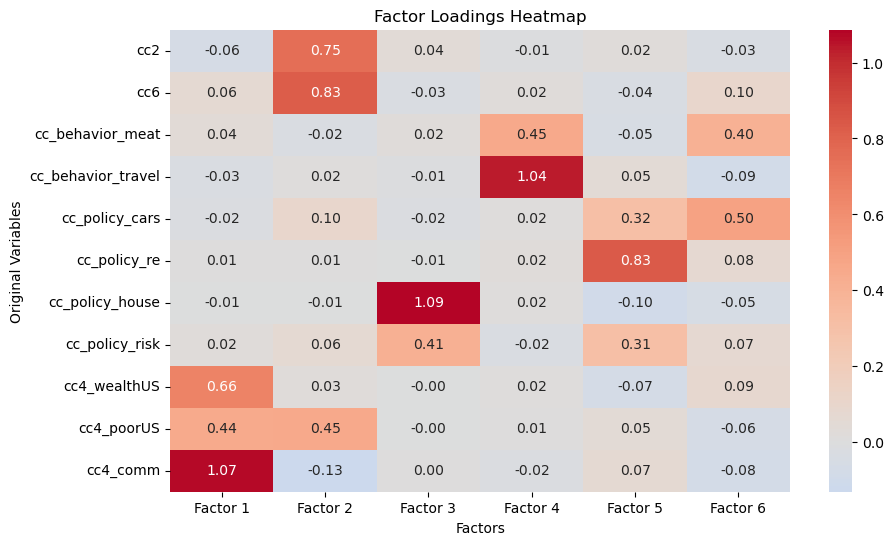

In [104]:
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadings, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Original Variables")
plt.show()

The heatmap shows how different variables group together based on their similarities. Factor 1 is mainly about concerns for communities and economic differences in climate change. Factor 2 is about personal climate-friendly behaviors. Factor 3 focuses on support for climate policies.

For the concept attitudes toward climate change I'm choosing the variables cc4_poorUS, cc4_comm, cc_behavior_travel, cc_behavior_meat, cc_policy_re and cc6.

<font size="4">Selected Variables for the concept *support for government interventions during COVID-19*: </font>

**cv_behavior_crowds** = To what extent, if any, do you take the following actions to reduce the spread of COVID-19 and address the pandemic?
Avoid large social gatherings or indoor crowds (like concerts or parties) 

**cv_behavior_mask** = To what extent, if any, do you take the following actions to reduce the spread of COVID-19 and address the pandemic?
Wear a mask regularly when in indoor public places 

**cv_behavior_store** =  To what extent, if any, do you take the following actions to reduce the spread of COVID-19 and address the pandemic?
Stock up on nonperishable goods to prepare for a possible future lockdown 

**cv_behavior_activ** = To what extent, if any, do you take the following actions to reduce the spread of COVID-19 and address the pandemic?
Engage in political campaigning or activism to promote public health 

**cv_behavior_discuss** =  To what extent, if any, do you take the following actions to reduce the spread of COVID-19 and address the pandemic?
Discuss the COVID-19 pandemic with family, friends, or members of your community 

**cv_policy_vax** = To what extent, if any, do you support or oppose the following government mandates or measures aimed at reducing the spread of COVID-19 and addressing the pandemic? Vaccinations against COVID-19 that are FDA-approved 

**cv_policy_mask** = To what extent, if any, do you support or oppose the following government mandates or measures aimed at reducing the spread of COVID-19 and addressing the pandemic? Masks in indoor public spaces 

**cv_policy_hosp** =To what extent, if any, do you support or oppose the following government mandates or measures aimed at reducing the spread of COVID-19 and addressing the pandemic? Increasing hospital capacity (e.g., more beds) and number of healthcare workers in training 


In [111]:
summarize_dataframe(w5w6_st[supportCV])

,CC_variable,n_missing,n_values,complete_rate,mean,sd,p0,p25,p50,p75,p100
0,cv_behavior_crowds,0,3376,1.0,0.604488,0.367506,0.0,0.25,0.750000,1.000000,1.0
1,cv_behavior_mask,0,3376,1.0,0.599970,0.389590,0.0,0.25,0.750000,1.000000,1.0
2,cv_behavior_store,0,3376,1.0,0.367150,0.316832,0.0,0.00,0.250000,0.500000,1.0
3,cv_behavior_activ,0,3376,1.0,0.109893,0.232605,0.0,0.00,0.000000,0.000000,1.0
4,cv_behavior_discuss,0,3376,1.0,0.497630,0.320119,0.0,0.25,0.500000,0.750000,1.0
5,cv_policy_vax,0,3376,1.0,0.711937,0.341021,0.0,0.50,0.833333,1.000000,1.0
6,cv_policy_mask,0,3376,1.0,0.638280,0.352336,0.0,0.50,0.666667,1.000000,1.0
7,cv_policy_hosp,0,3376,1.0,0.705766,0.249183,0.0,0.50,0.666667,0.833333,1.0


For the variables representing the concept of support for government intervention there are no NaN values and there are 8015 rows in over wave 5 and 6.

The following histogram plots present the distribution of data for the variables reflecting support for government interventions.

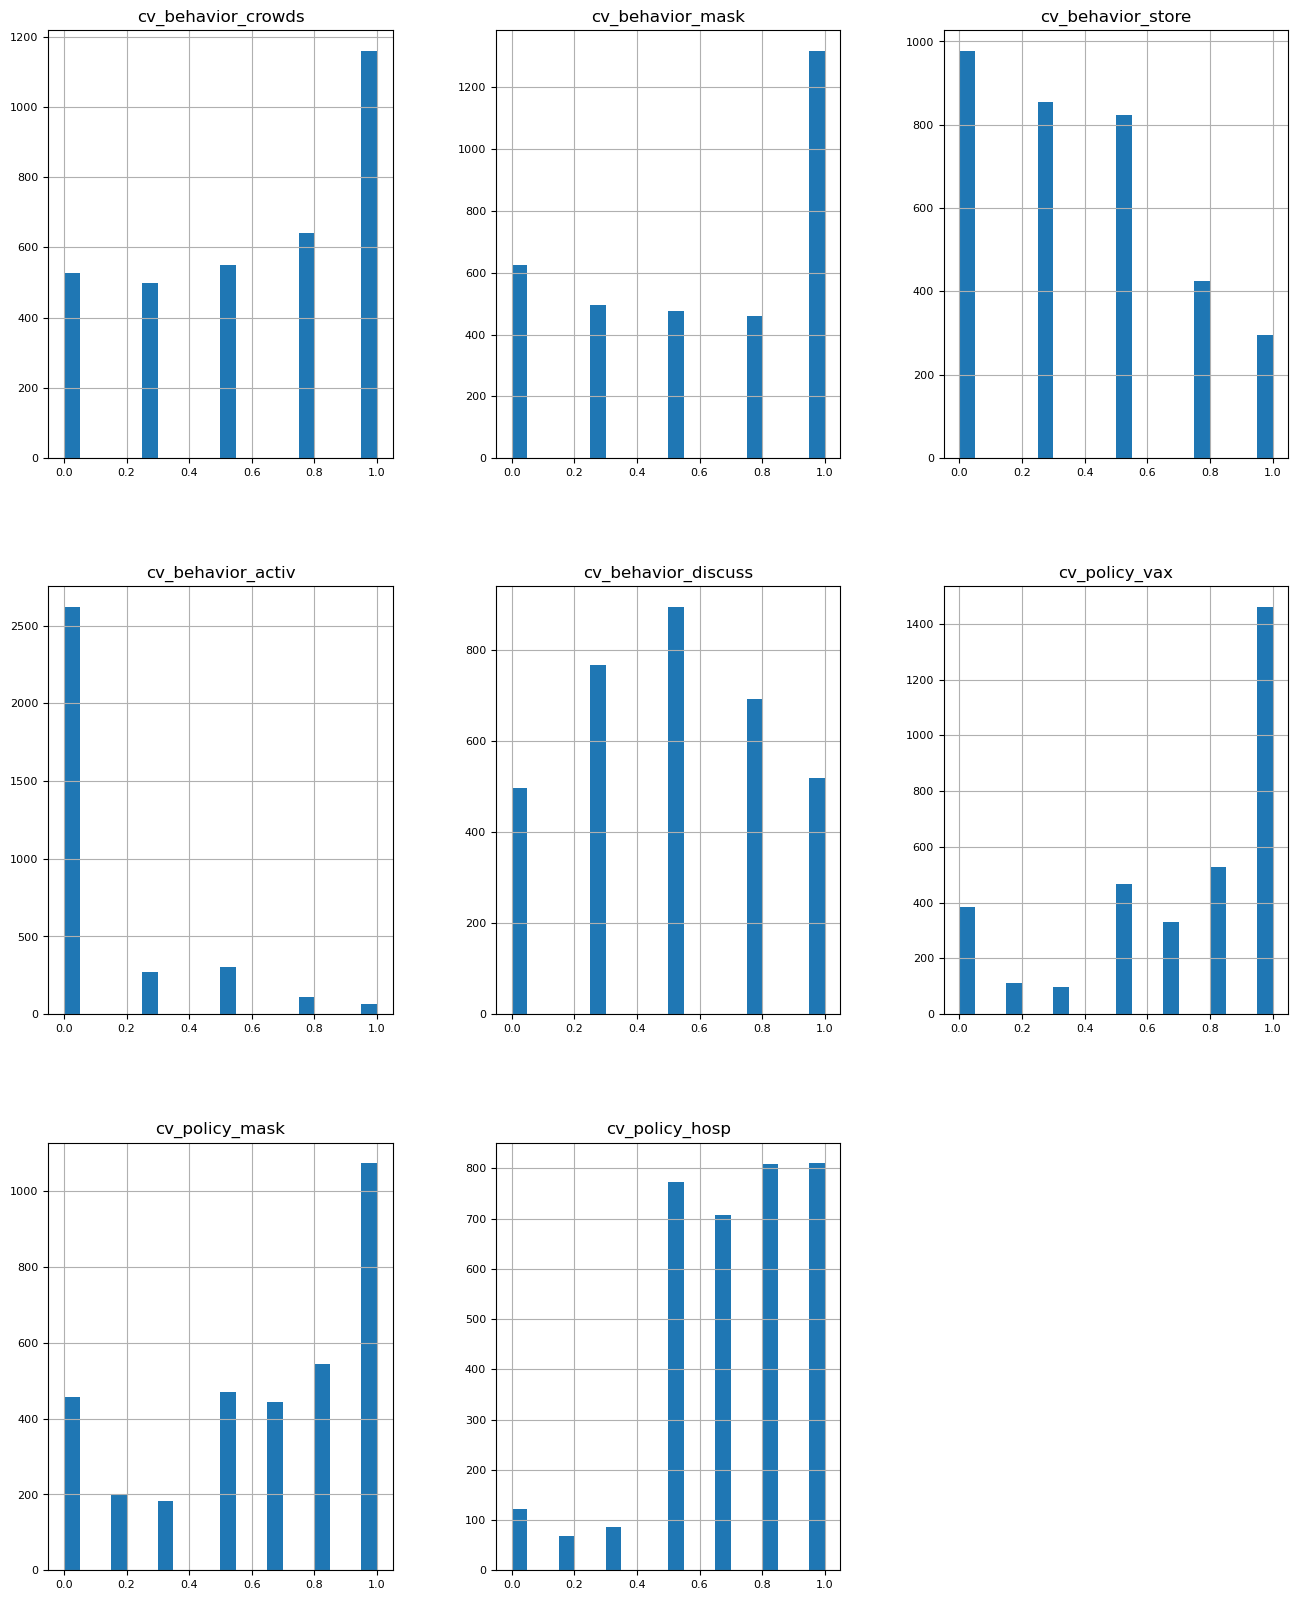

In [114]:
w5w6_st[supportCV].hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8); 

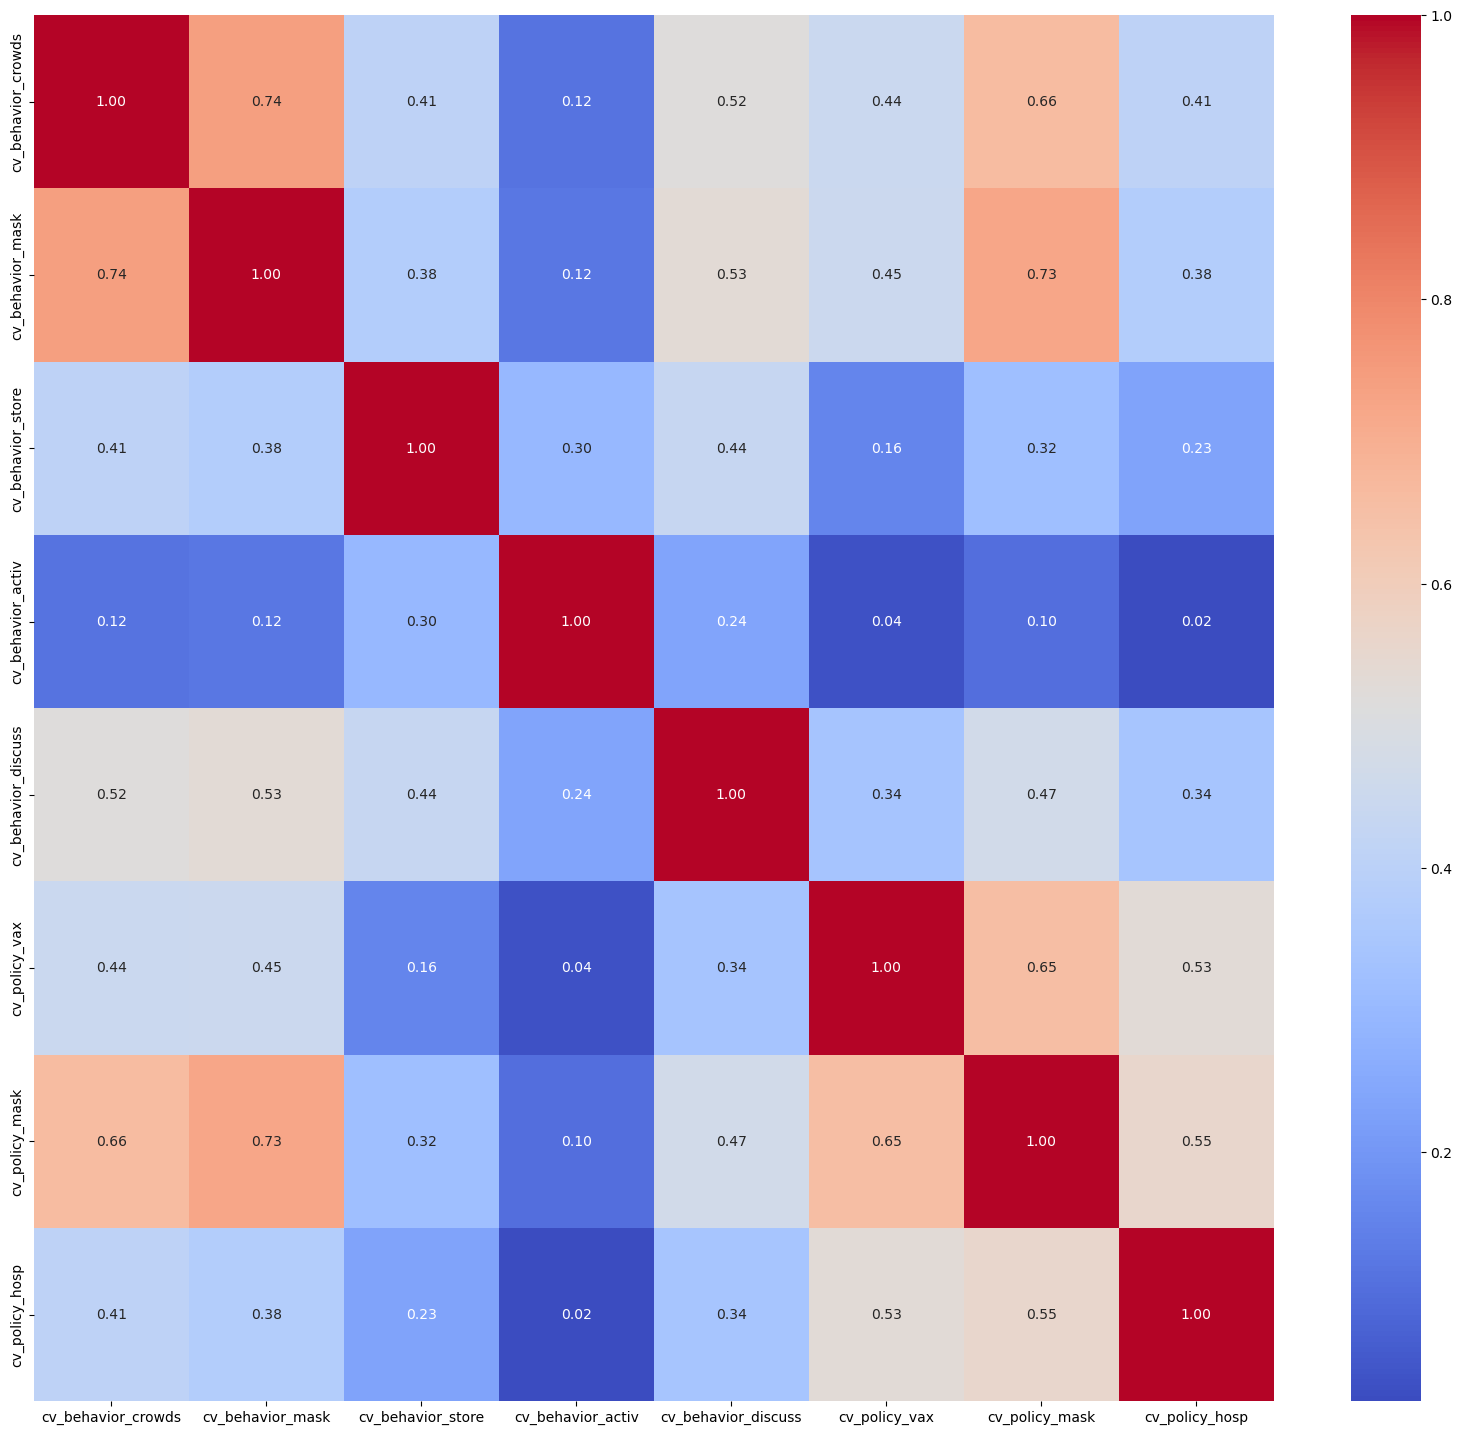

In [115]:
# Compute Spearman correlation
spearman_corr_CV = w5w6_st[supportCV].corr(method='spearman')

# Visualize with a heatmap
plt.figure(figsize=(20, 18)) 
sns.heatmap(
    spearman_corr_CV,
    annot=True,         
    fmt=".2f",        
    cmap='coolwarm',     
    cbar=True            
)
plt.show()

The variables cv_policy_vax, cv_policy_mask, and cv_policy_hosp are highly correlated. Similarly, cv_behavior_crowds and cv_behavior_mask show a strong correlation, as do cv_policy_mask, cv_behavior_mask, and cv_behavior_crowds. This is expected because they all relate to public health measures and behavioral responses to policies.

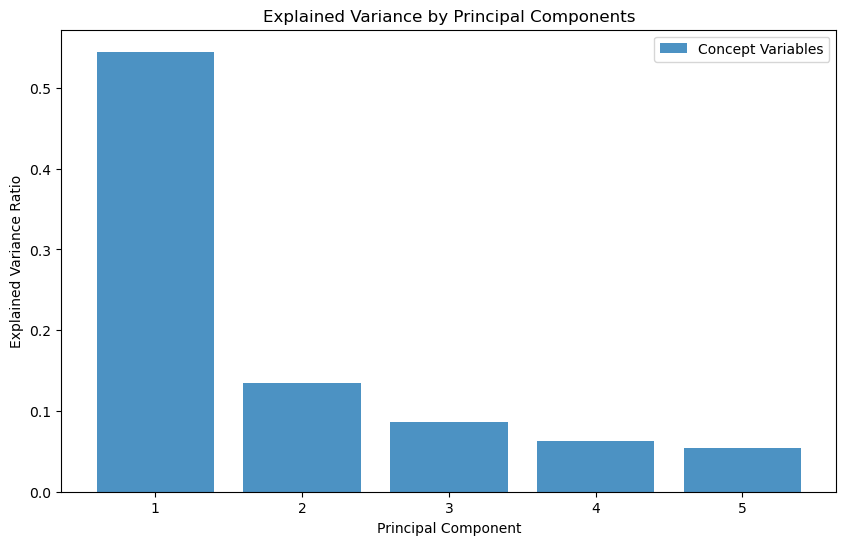

Explained Variance (Concept Variables - Support CV interventions): [0.54484051 0.1346331  0.08666192 0.06313302 0.054321  ]


In [119]:
pca_conceptsCV = PCA(n_components=5)
pca_conceptsCV.fit(w5w6_st[supportCV])

explained_variance_concepts = pca_conceptsCV.explained_variance_ratio_

plt.figure(figsize=(10, 6))
# Concept Variables
plt.bar(range(1, len(explained_variance_concepts) + 1), explained_variance_concepts, alpha=0.8, label="Concept Variables")

plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.show()

print("Explained Variance (Concept Variables - Support CV interventions):", explained_variance_concepts)

The Principal Component Analysis (PCA) reveals the proportion of variance explained by each principal component. The bar plot above shows that the first principal component accounts for 0.5132 of the variance, while the first three components collectively explain around 0.75 of the variance. To reduce dimensionality, it would be useful to examine the loadings of the first three principal components to understand what the variables contribute to the principal component.

                          PC1       PC2       PC3       PC4       PC5
cv_behavior_crowds   0.464643  0.114162  0.368860 -0.125946 -0.150964
cv_behavior_mask     0.502545  0.085575  0.498642 -0.029844  0.193096
cv_behavior_store    0.241563  0.588778 -0.439542 -0.523574 -0.233977
cv_behavior_activ    0.074769  0.284412 -0.277717  0.010494  0.812586
cv_behavior_discuss  0.322110  0.329670 -0.214729  0.830794 -0.163429
cv_policy_vax        0.338792 -0.561424 -0.454393 -0.008348  0.158758
cv_policy_mask       0.451187 -0.289213 -0.015893 -0.135087  0.117143
cv_policy_hosp       0.213326 -0.211118 -0.303545 -0.021659 -0.399057


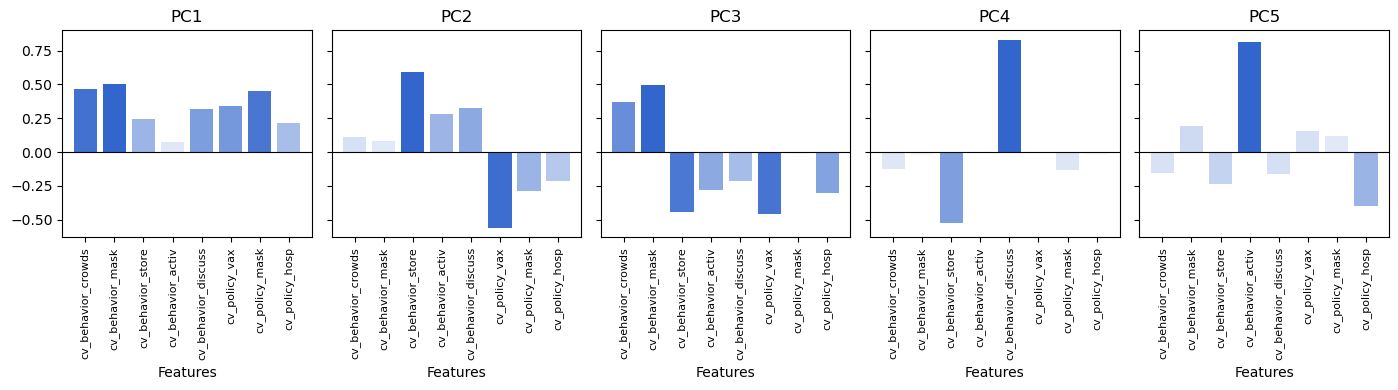

In [123]:
# Get loadings
loadingsCV = pd.DataFrame(
    pca_conceptsCV.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_conceptsCV.components_))],
    index=supportCV 
)
print(loadingsCV)

# subplots
fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)

for i in range(5):
    ax = axes[i]
    pc_loadings = loadingsCV[f'PC{i+1}']

    # color intensity
    colors = get_bar_colors(pc_loadings)

    #  plot
    ax.bar(loadingsCV.index, pc_loadings, color=colors)
    
    ax.axhline(0, color='black', linewidth=0.8)
    ax.xaxis.set_ticks(pc_loadings.index)
    ax.set_xticklabels(loadingsCV.index, rotation=90, fontsize=8)
    ax.set_title(f"PC{i+1}")
    ax.set_xlabel("Features")
    
plt.tight_layout()
plt.show()

The variables cv_behavior_crowds, cv_behavior_mask, cv_policy_mask, cv_behavior_discuss, and cv_policy_vax contribute the most to the variance of the first principal component. For the second principal component, the most relevant variables are cv_behavior_store, cv_behavior_activ, and cv_policy_vax. In the third principal component, the contributors are primarily cv_policy_vax, cv_behavior_activ, cv_behavior_mask, and cv_behavior_crowds. 

In [125]:
# Run Factor Analysis
faCV = FactorAnalyzer(n_factors=6)
faCV.fit(w5w6_st[supportCV])

# Get Factor Loadings
factor_loadingsCV = pd.DataFrame(
    faCV.loadings_, 
    index=supportCV, 
    columns=[f'Factor {i+1}' for i in range(6)]
)

print(factor_loadingsCV)

                     Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  \
cv_behavior_crowds   0.861770  0.083579 -0.016206  0.088555 -0.030512   
cv_behavior_mask     0.874891 -0.078844 -0.066702 -0.046888  0.124689   
cv_behavior_store    0.105323 -0.041308  0.369399  0.482149 -0.019061   
cv_behavior_activ   -0.071049  0.012143  0.552029  0.052970  0.029321   
cv_behavior_discuss  0.238271  0.042099  0.116203  0.000877  0.489313   
cv_policy_vax        0.058379  0.804042  0.070809 -0.127766  0.000893   
cv_policy_mask       0.410809  0.480353  0.043935  0.060961 -0.102127   
cv_policy_hosp      -0.135383  0.628154 -0.095670  0.279298  0.080137   

                     Factor 6  
cv_behavior_crowds  -0.179826  
cv_behavior_mask     0.078201  
cv_behavior_store   -0.007258  
cv_behavior_activ    0.011418  
cv_behavior_discuss -0.021001  
cv_policy_vax        0.000283  
cv_policy_mask       0.214230  
cv_policy_hosp       0.024881  


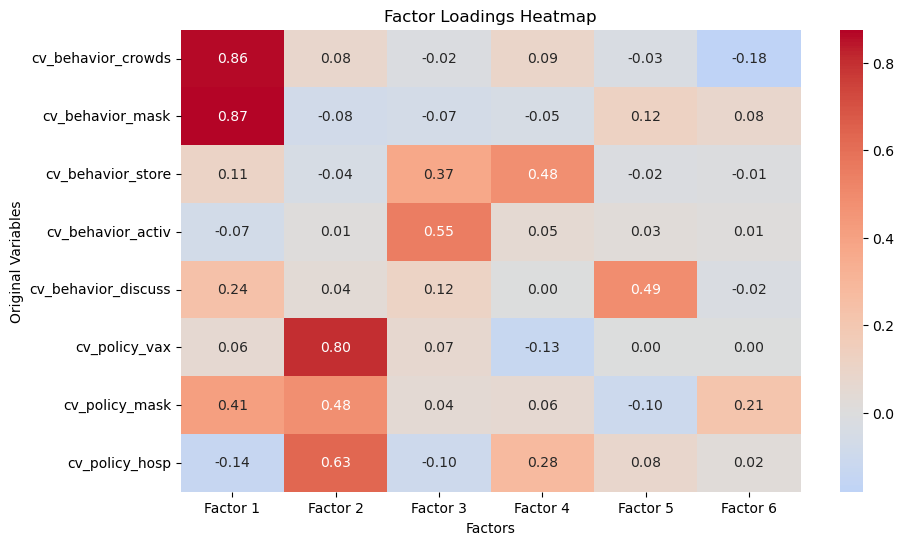

In [126]:
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadingsCV, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Original Variables")
plt.show()

The factor loadings heatmap shows that Factor 1 is linked to personal behaviors, as cv_behavior_mask and cv_behavior_crowds load highly. Factor 2 represents policy support, with strong loadings on cv_policy_vax, cv_policy_mask, and cv_policy_hosp.

For this concept I'm selecting cv_behavior_crowds, cv_behavior_mask, cv_policy_mask, cv_policy_vax and cv_behavior_activ.

<font size="4">Selected Variables for the concept *Trust in Authority Figures and Organizations*: </font>

**pol_trust_pres** = How much do you trust each of the following to act in the best interests of the public? The President (Joe Biden) 

**pol_trust_cong** = How much do you trust each of the following to act in the best interests of the public? Congress

**pol_trust_state** = How much do you trust each of the following to act in the best interests of the public? State government / governor 

**pol_trust_local** = How much do you trust each of the following to act in the best interests of the public? Local government / mayor 

**pol_trust_cdc** = How much do you trust each of the following to act in the best interests of the public? The Center for Disease Control (the CDC) 

**pol_trust_fema** = How much do you trust each of the following to act in the best interests of the public? The Federal Emergency Management Agency (FEMA) 

**pol_trust_news** = How much do you trust each of the following to act in the best interests of the public? Most news media 

**pol_trust_bus** = How much do you trust each of the following to act in the best interests of the public? Business leaders 

**pol_trust_sci** = How much do you trust each of the following to act in the best interests of the public? Scientists

**pol_trust_police** = How much do you trust each of the following to act in the best interests of the public? The police

In [132]:
summarize_dataframe(w5w6_st[trust])

,CC_variable,n_missing,n_values,complete_rate,mean,sd,p0,p25,p50,p75,p100
0,pol_trust_pres,0,3376,1.0,0.441252,0.381771,0.0,0.000000,0.333333,0.666667,1.0
1,pol_trust_cong,0,3376,1.0,0.328693,0.259302,0.0,0.000000,0.333333,0.333333,1.0
2,pol_trust_state,0,3376,1.0,0.483017,0.311494,0.0,0.333333,0.666667,0.666667,1.0
3,pol_trust_local,0,3376,1.0,0.535150,0.272072,0.0,0.333333,0.666667,0.666667,1.0
4,pol_trust_fema,0,3376,1.0,0.572670,0.283281,0.0,0.333333,0.666667,0.666667,1.0
5,pol_trust_bus,0,3376,1.0,0.476698,0.246890,0.0,0.333333,0.333333,0.666667,1.0
6,pol_trust_sci,0,3376,1.0,0.674961,0.281905,0.0,0.666667,0.666667,1.000000,1.0


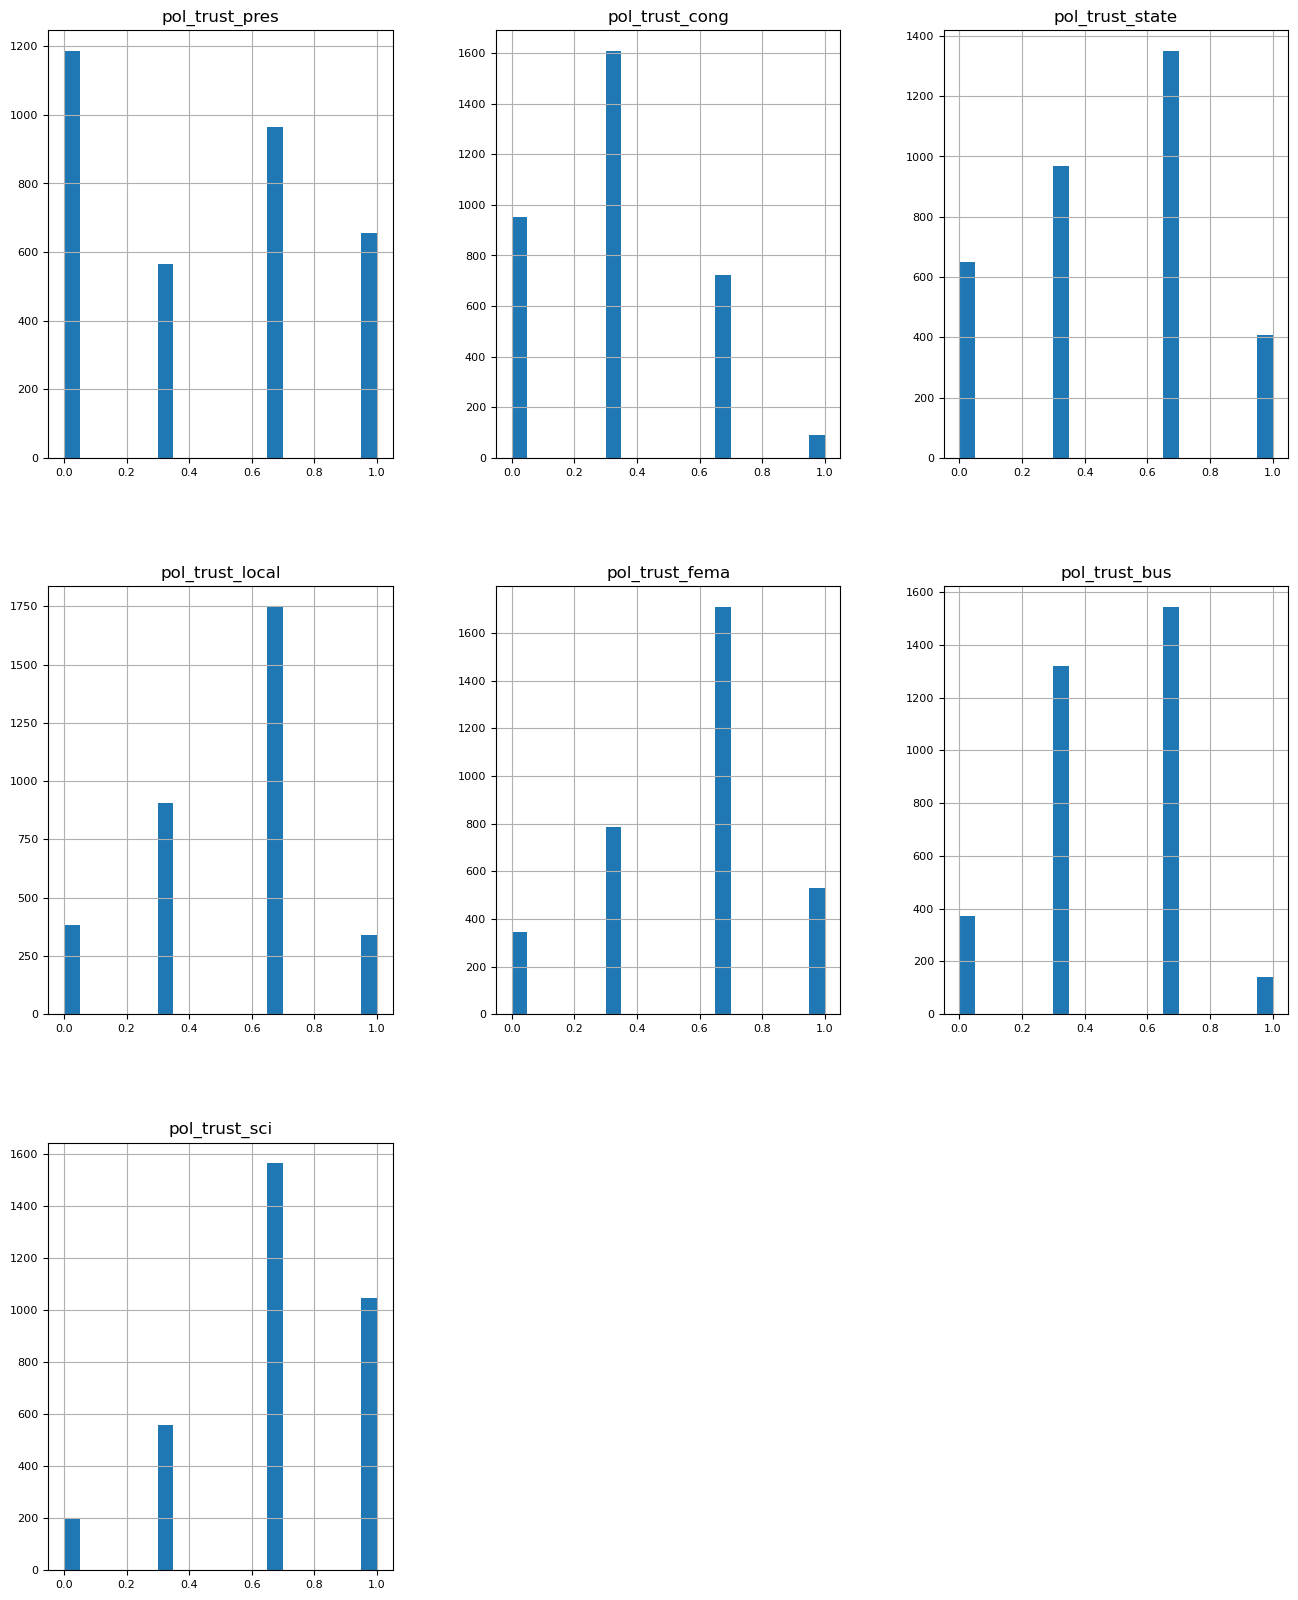

In [134]:
w5w6_st[trust].hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8); 

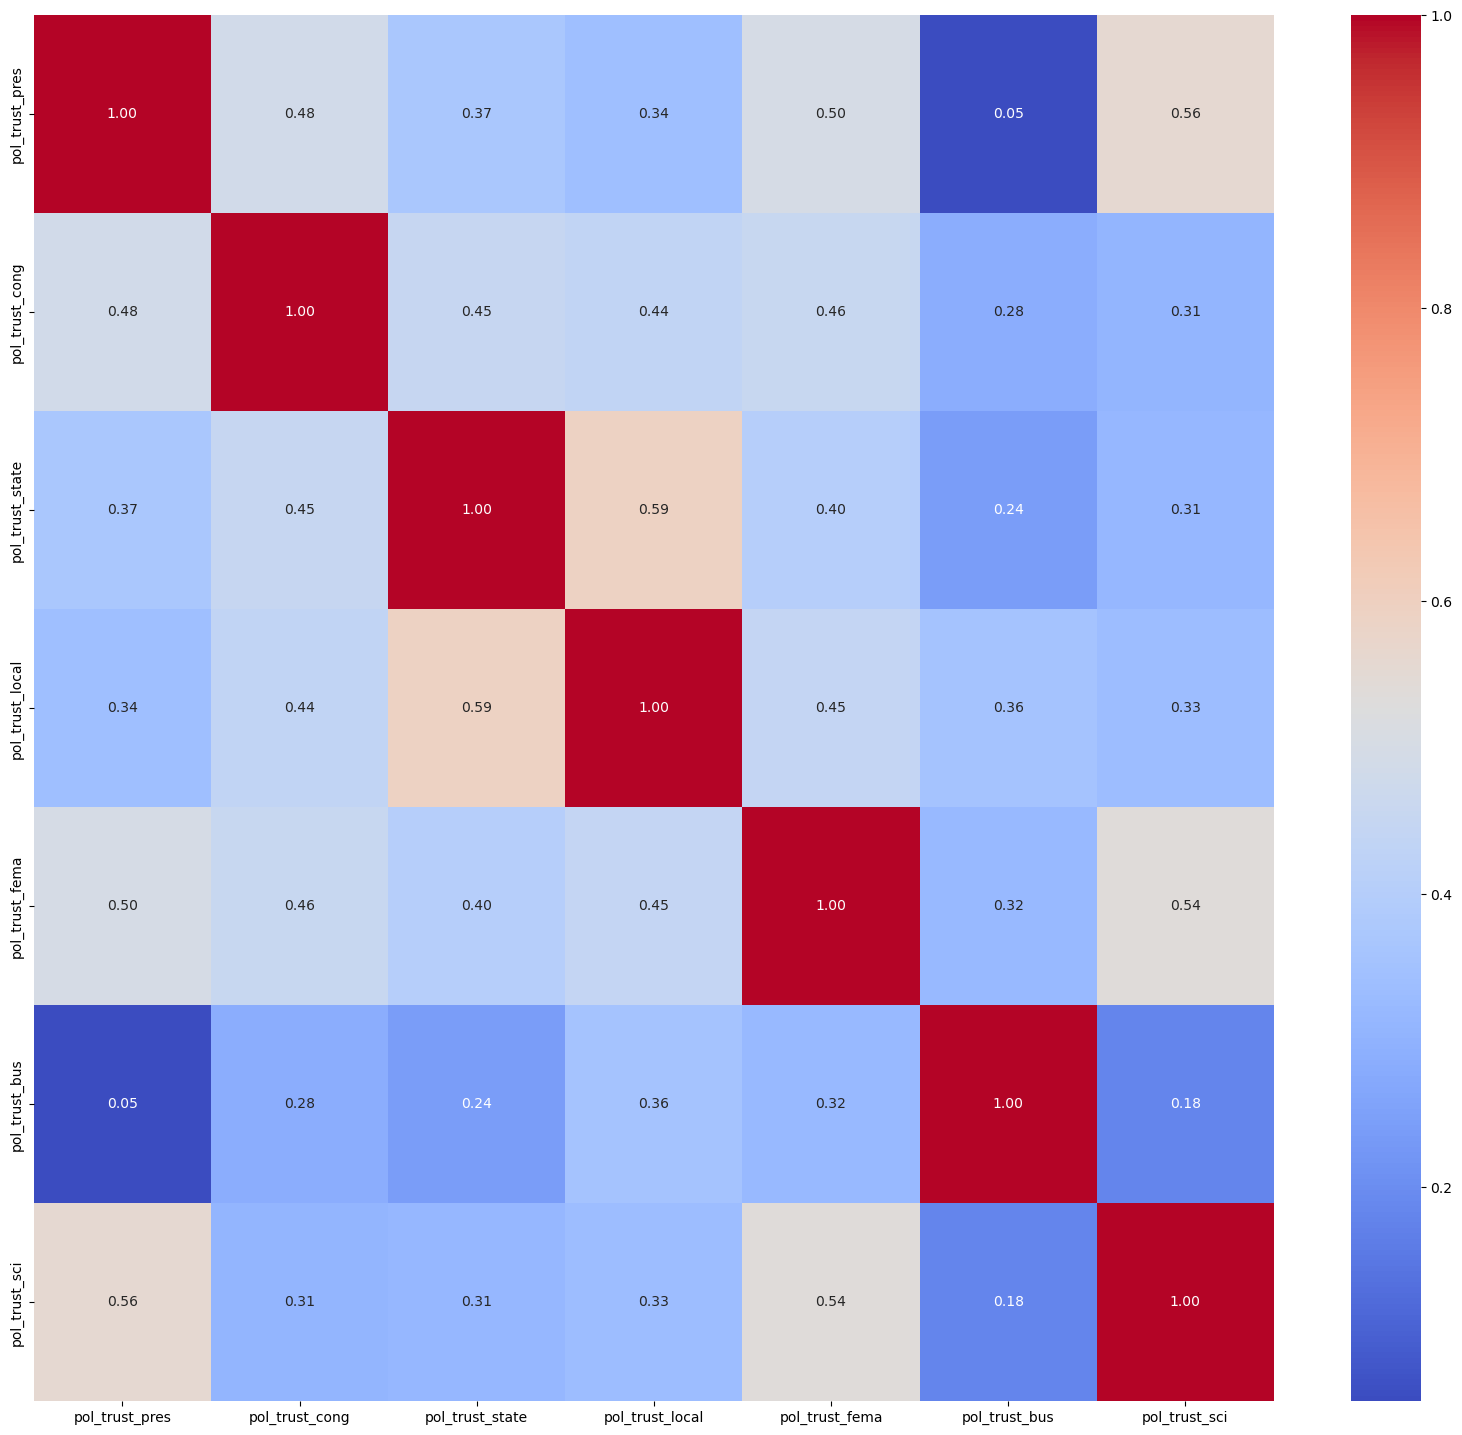

In [135]:
#Compute Spearman correlation
spearman_corr_trust = w5w6_st[trust].corr(method='spearman')

plt.figure(figsize=(20, 18)) 
sns.heatmap(
    spearman_corr_trust,
    annot=True,        
    fmt=".2f",           
    cmap='coolwarm',   
    cbar=True          
)
plt.show()

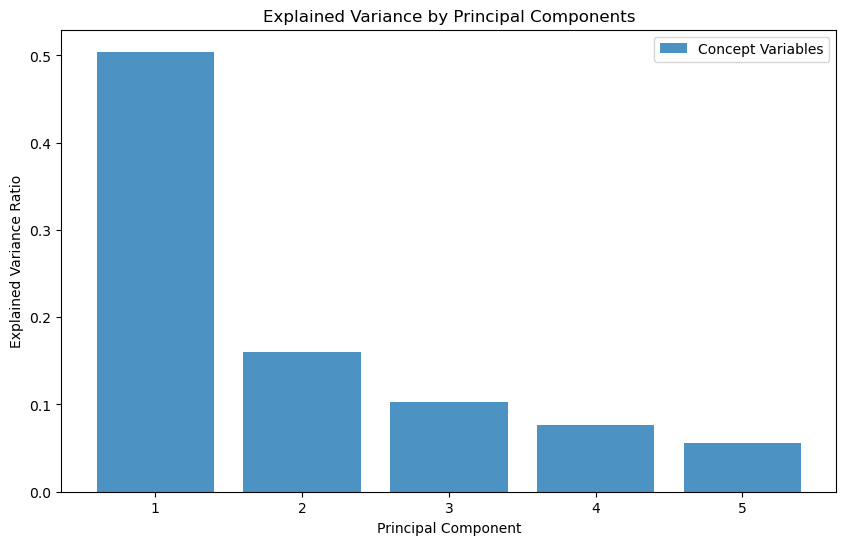

Explained Variance (Concept Variables - trust in authority figures and organizations): [0.50426426 0.15961063 0.10307583 0.07667273 0.05631176]


In [137]:
pca_conceptstrust = PCA(n_components=5)
pca_conceptstrust.fit(w5w6_st[trust])

explained_variance_concepts = pca_conceptstrust.explained_variance_ratio_

plt.figure(figsize=(10, 6))
# Concept Variables
plt.bar(range(1, len(explained_variance_concepts) + 1), explained_variance_concepts, alpha=0.8, label="Concept Variables")

plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.show()

print("Explained Variance (Concept Variables - trust in authority figures and organizations):", explained_variance_concepts)

                      PC1       PC2       PC3       PC4       PC5
pol_trust_pres   0.557606  0.639518  0.237074  0.229631 -0.320194
pol_trust_cong   0.325982 -0.107440  0.091013  0.625042  0.417074
pol_trust_state  0.394152 -0.445682  0.531540 -0.331418  0.068076
pol_trust_local  0.339973 -0.402995  0.115509 -0.095620 -0.306454
pol_trust_fema   0.393027 -0.038279 -0.429486 -0.106734  0.612460
pol_trust_bus    0.163507 -0.417787 -0.514668  0.387174 -0.486706
pol_trust_sci    0.361482  0.205970 -0.436226 -0.525657 -0.113965


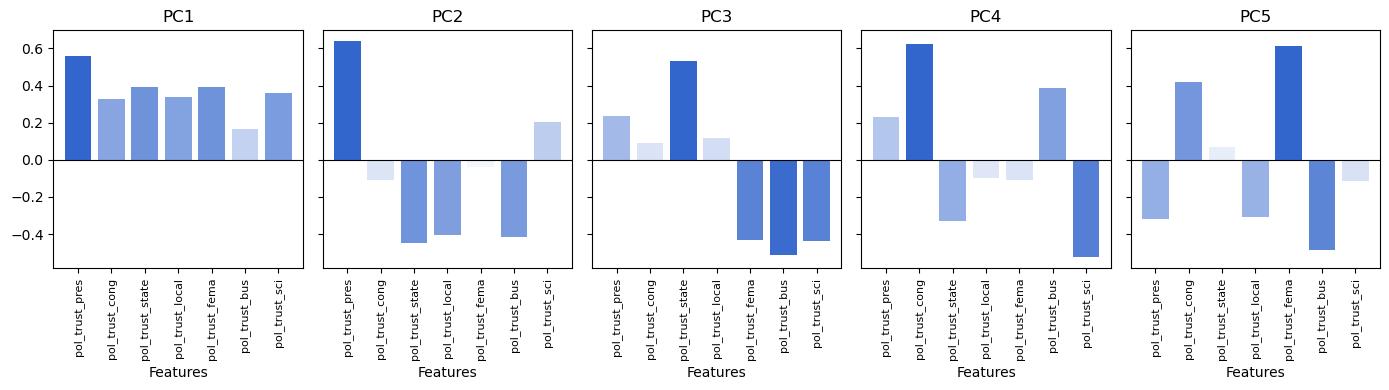

In [140]:
# Get loadings
loadingstrust = pd.DataFrame(
    pca_conceptstrust.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_conceptstrust.components_))],
    index=trust
)
print(loadingstrust)

# subplots
fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)

for i in range(5):
    ax = axes[i]
    pc_loadings = loadingstrust[f'PC{i+1}']

    # color intensity
    colors = get_bar_colors(pc_loadings)

    #  plot
    ax.bar(loadingstrust.index, pc_loadings, color=colors)
    
    ax.axhline(0, color='black', linewidth=0.8)
    ax.xaxis.set_ticks(pc_loadings.index)
    ax.set_xticklabels(loadingstrust.index, rotation=90, fontsize=8)
    ax.set_title(f"PC{i+1}")
    ax.set_xlabel("Features")
    
plt.tight_layout()
plt.show()

In [142]:
# Run Factor Analysis
fatrust = FactorAnalyzer(n_factors=6)
fatrust.fit(w5w6_st[trust])

# Get Factor Loadings
factor_loadingstrust = pd.DataFrame(
    fatrust.loadings_, 
    index=trust, 
    columns=[f'Factor {i+1}' for i in range(6)]
)

print(factor_loadingstrust)

                 Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6
pol_trust_pres  -0.022593  0.419950  0.382172 -0.162436 -0.030401  0.269234
pol_trust_cong   0.059513 -0.049425  0.696732  0.149419  0.025869  0.002631
pol_trust_state  0.782121  0.053619  0.111920 -0.117121 -0.021505 -0.055748
pol_trust_local  0.684892 -0.045279 -0.096375  0.148608  0.022661  0.249391
pol_trust_fema   0.010533  0.318508  0.042132 -0.003267  0.543289 -0.000770
pol_trust_bus   -0.010436  0.039987  0.077349  0.661753 -0.017499 -0.002179
pol_trust_sci    0.022804  0.795936 -0.091903  0.116533  0.021084  0.001427


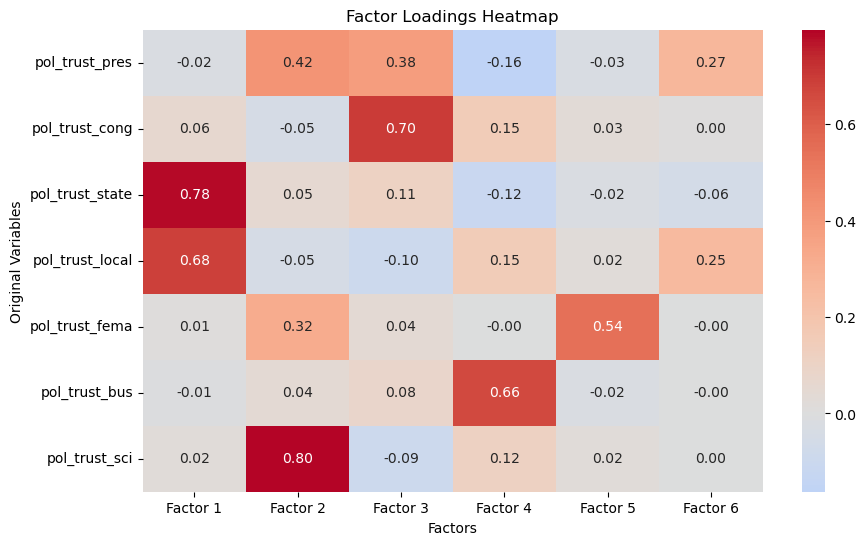

In [143]:
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadingstrust, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Original Variables")
plt.show()

<font size="4">Selected Variables for the concept *harm due to experience extreme weather*: </font>

**ew3_phy** = Taking the extreme weather event that impacted you the most in the last ten years, how much were you personally harmed by this event? Physically (e.g. bodily harm)

**ew3_mat** = Taking the extreme weather event that impacted you the most in the last ten years, how much were you personally harmed by this event? Materially (e.g. property damage)

**ew3_fin** = Taking the extreme weather event that impacted you the most in the last ten years, how much were you personally harmed by this event? Financially (e.g. job or income loss)

**ew3_men** = Taking the extreme weather event that impacted you the most in the last ten years, how much were you personally harmed by this event? Mentally (e.g. emotional or psychological hardship)

In [145]:
summarize_dataframe(w5w6_st[ew3])

,CC_variable,n_missing,n_values,complete_rate,mean,sd,p0,p25,p50,p75,p100
0,ew3_phy,681,2695,0.798282,0.105257,0.223974,0.0,0.0,0.000000,0.000000,1.0
1,ew3_mat,681,2695,0.798282,0.210390,0.273329,0.0,0.0,0.000000,0.333333,1.0
2,ew3_fin,681,2695,0.798282,0.158318,0.260715,0.0,0.0,0.000000,0.333333,1.0
3,ew3_men,681,2695,0.798282,0.247743,0.284343,0.0,0.0,0.333333,0.333333,1.0


There are some missing values in the data. I assume this is because 1,541 people have never experienced an extreme weather event, so they have not responded to questions about the harm they've experienced.

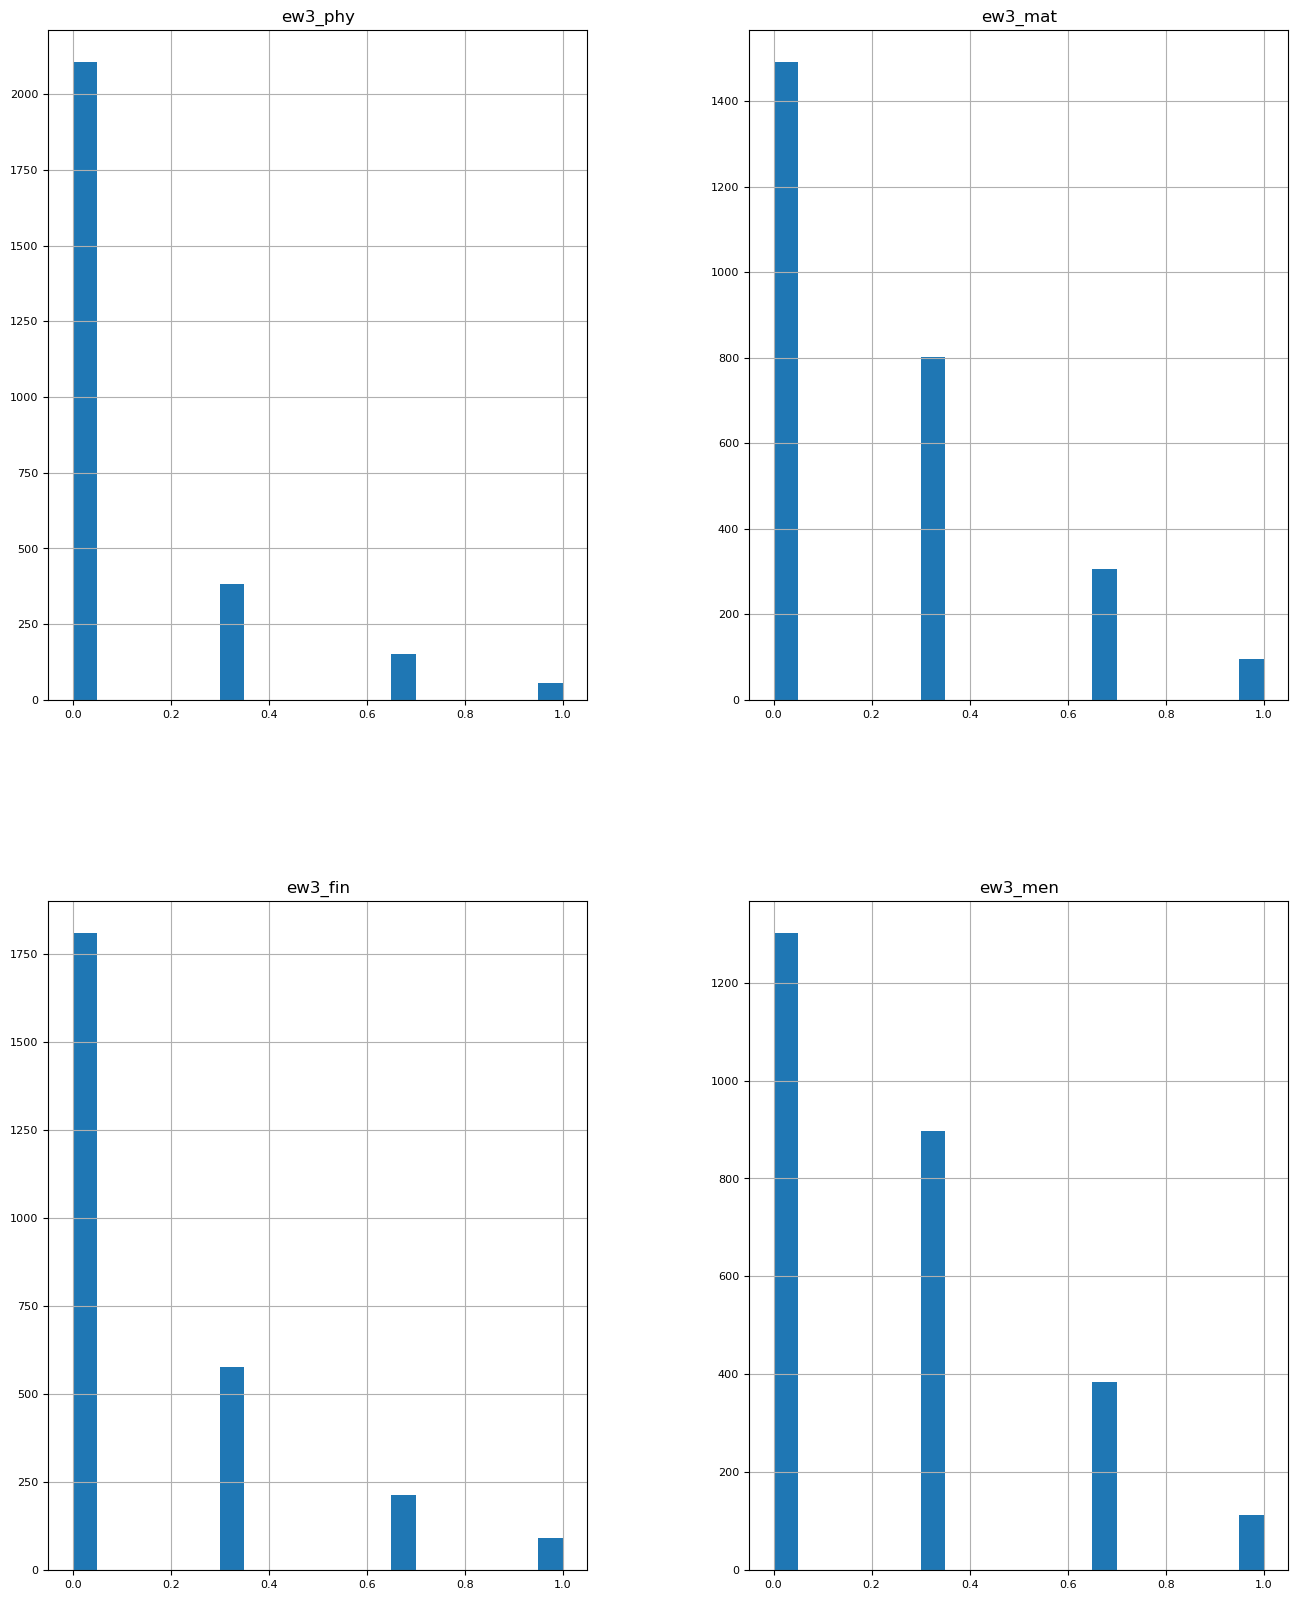

In [149]:
w5w6_st[ew3].hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8); 

More people report experiencing very little harm, resulting in a skewed histogram distribution.

Below you'll find the Spearman correlation matrix containing all the variables.

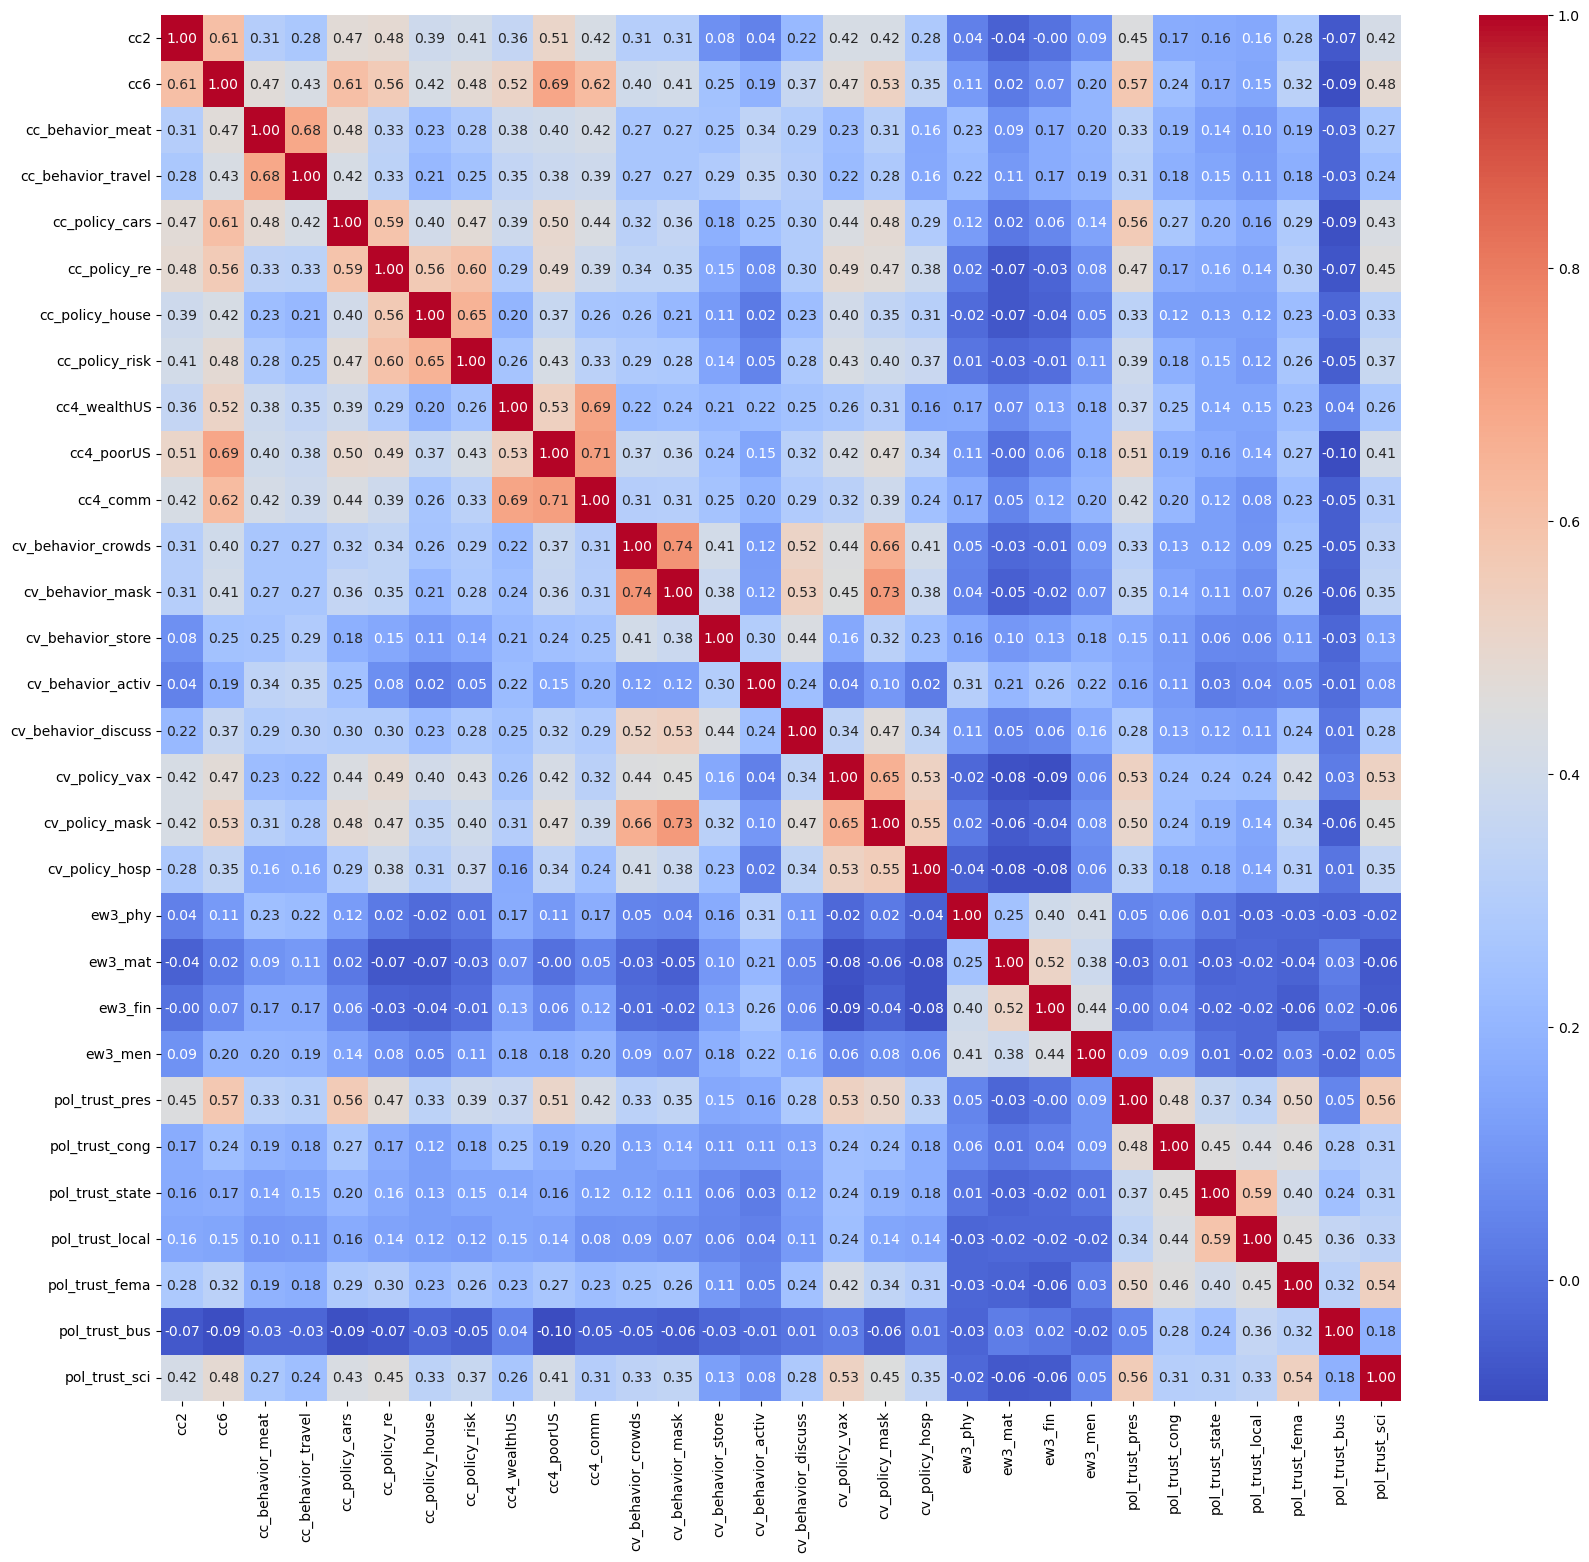

In [155]:
#Compute Spearman correlation
spearman_corr_all = w5w6_st[selected_columns].corr(method='spearman')

plt.figure(figsize=(20, 18)) 
sns.heatmap(
    spearman_corr_all,
    annot=True,        
    fmt=".2f",           
    cmap='coolwarm',   
    cbar=True          
)
plt.show()

In [158]:
# Run Factor Analysis
fa_all = FactorAnalyzer(n_factors=8)
fa_all.fit(w5w6_st[selected_columns])

# Get Factor Loadings
factor_loadings_all = pd.DataFrame(
    fa_all.loadings_, 
    index=selected_columns, 
    columns=[f'Factor {i+1}' for i in range(8)]
)

print(factor_loadings_all)

                     Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  \
cc2                 -0.026588  0.225141  0.217278  0.379027  0.023154   
cc6                  0.025796  0.401077  0.169693  0.332572  0.039847   
cc_behavior_meat    -0.086070 -0.038887  0.044815  0.105923 -0.064617   
cc_behavior_travel  -0.034920 -0.038371  0.043943  0.025411 -0.059943   
cc_policy_cars      -0.030583 -0.017399  0.261963  0.293137  0.012886   
cc_policy_re        -0.005362 -0.006236  0.584581  0.215378 -0.015473   
cc_policy_house     -0.065504 -0.043518  0.918237 -0.095285 -0.006404   
cc_policy_risk      -0.041156  0.004555  0.931575 -0.097050  0.025374   
cc4_wealthUS        -0.041944  0.799351 -0.040446 -0.066093 -0.020179   
cc4_poorUS           0.038630  0.673373  0.113524  0.135538 -0.003183   
cc4_comm             0.001865  1.002038 -0.009882 -0.075135 -0.018650   
cv_behavior_crowds   0.873856 -0.023551 -0.039279  0.025012 -0.021153   
cv_behavior_mask     0.892771 -0.049551 -0.157857  

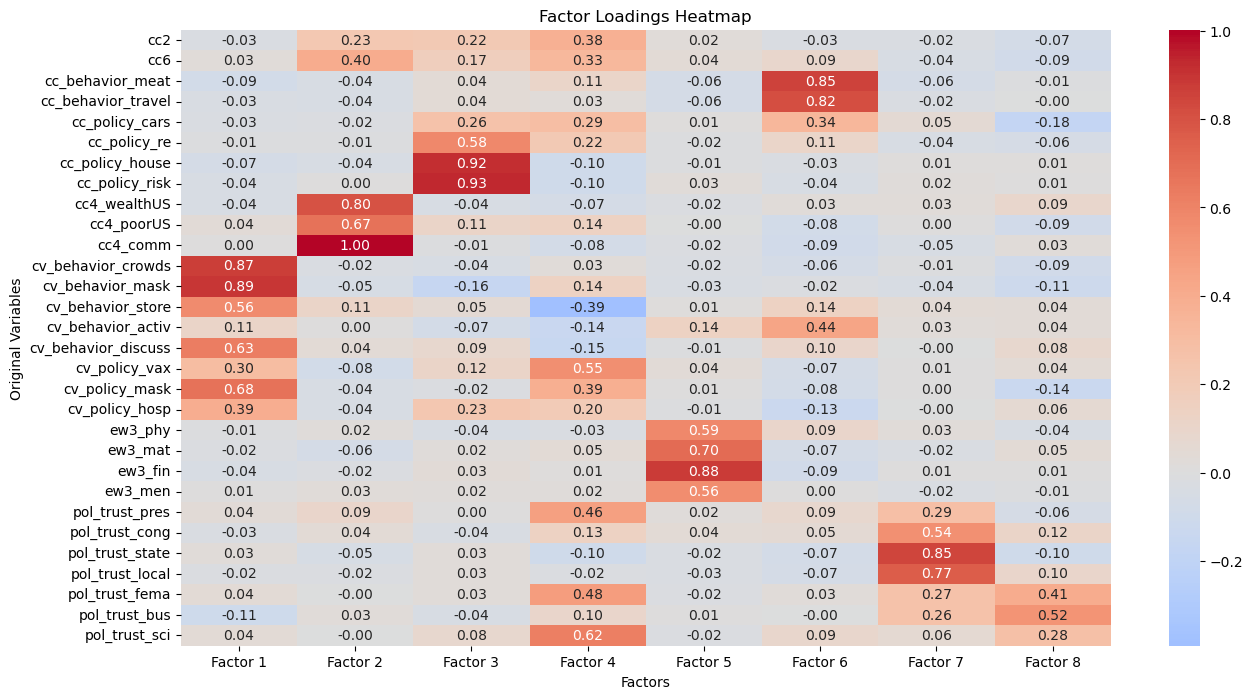

In [159]:
plt.figure(figsize=(15, 8))
sns.heatmap(factor_loadings_all, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Original Variables")
plt.show()

Factor Analysis shows us which variables represent the same concept. The heat map above shows the following concepts: trust in government figures and organizations, harm experienced due to extreme weather events, people adapting their behavior because of COVID-19, people adapting their behavior because of climate change, worry about climate change (except cc2; is about what causes the rising temperatures, natural activities or human behavior), support for climate change government interventions, support for COVID-19 government interventions.

<font size="4"> *Aggregating the concept variables:* </font>

For the concept support for climage change interventions (policy):
**cc_policy_cars, cc_policy_re, cc_policy_house, cc_policy_risk**

For the concept attitudes toward climate change: 
**cc2, cc6, cc4_wealthUS, cc4_poorUS, cc4_comm, cc_behavior_meat**

For the concept support for government interventions during COVID-19:
**cv_policy_mask, cv_policy_vax, cv_policy_hosp, cv_behavior_crowds, cv_behavior_mask**

For the concept trust in authority figures and organizations:
**pol_trust_local, pol_trust_pres, pol_trust_cong, pol_trust_state, pol_trust_fema**

For the concept harm experienced due to extreme weather events:
**ew3_phy, ew3_mat, ew3_fin, ew3_men**

Below you'll find the distributions of the aggregated variables. 

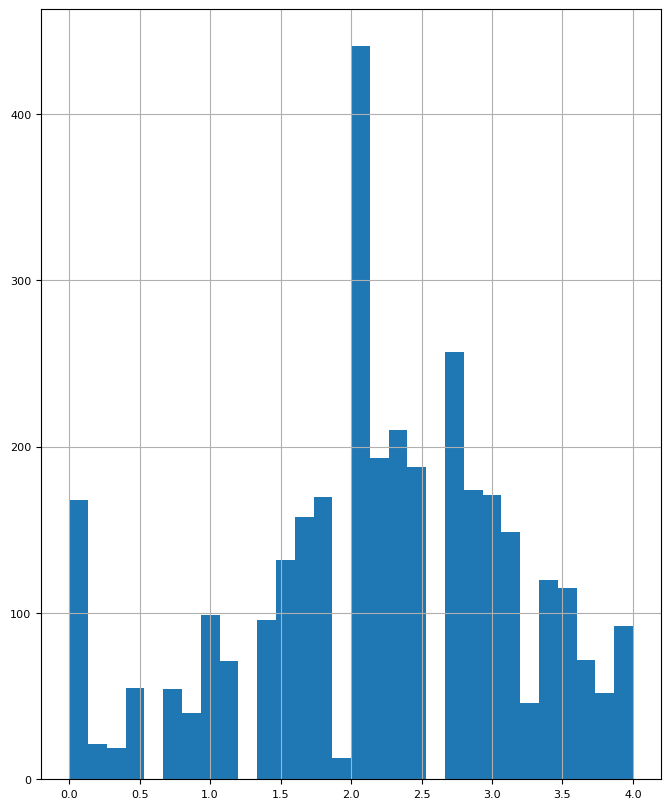

In [163]:
w5w6_st['support_cc_policy'] = w5w6_st['cc_policy_cars'] + w5w6_st['cc_policy_re'] + w5w6_st['cc_policy_house'] + w5w6_st['cc_policy_risk']
w5w6_st['attitudes_cc'] = w5w6_st['cc2'] + w5w6_st['cc6'] + w5w6_st['cc4_wealthUS'] + w5w6_st['cc4_poorUS'] + w5w6_st['cc4_comm'] + w5w6_st['cc_behavior_meat']
w5w6_st['support_govern_cv'] = w5w6_st['cv_policy_mask'] + w5w6_st['cv_policy_vax'] + w5w6_st['cv_policy_hosp'] + w5w6_st['cv_behavior_crowds'] + w5w6_st['cv_behavior_mask']
w5w6_st['trust_officials'] = w5w6_st['pol_trust_local'] + w5w6_st['pol_trust_pres'] + w5w6_st['pol_trust_cong'] + w5w6_st['pol_trust_state'] + w5w6_st['pol_trust_fema']
w5w6_st['harm_ex_weather'] = w5w6_st['ew3_phy'] + w5w6_st['ew3_mat'] + w5w6_st['ew3_fin'] + w5w6_st['ew3_men']

w5w6_st['support_cc_policy'].hist(figsize=(8, 10), bins=30, xlabelsize=8, ylabelsize=8); 

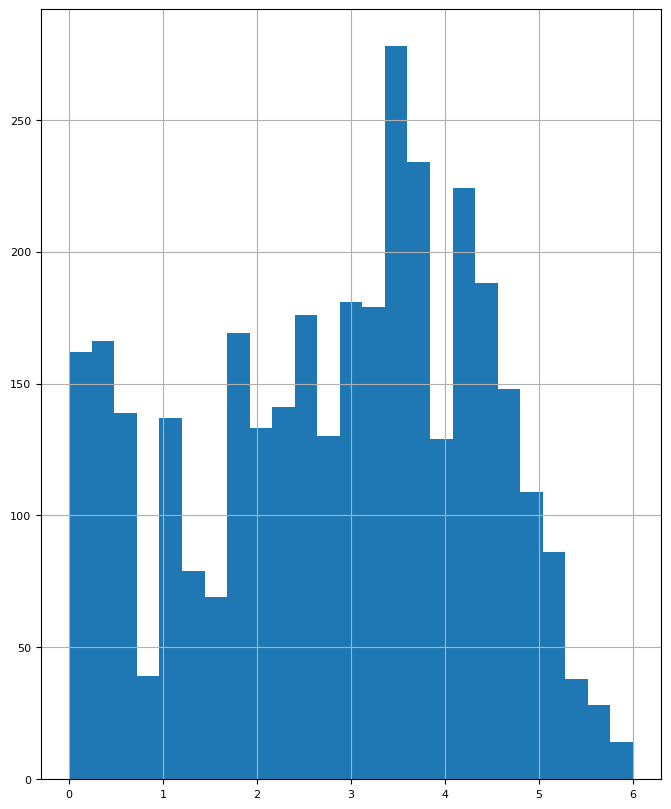

In [164]:
w5w6_st['attitudes_cc'].hist(figsize=(8, 10), bins=25, xlabelsize=8, ylabelsize=8);

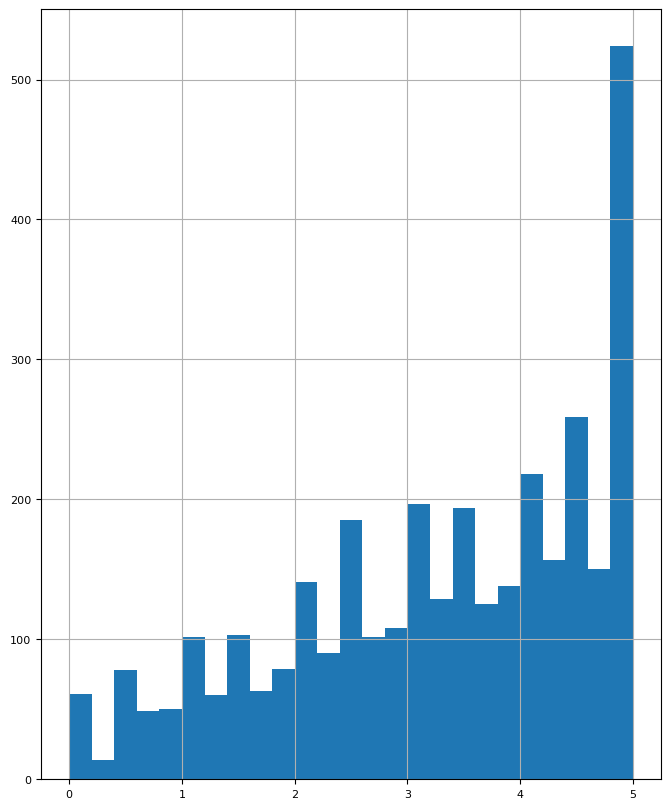

In [166]:
w5w6_st['support_govern_cv'].hist(figsize=(8, 10), bins=25, xlabelsize=8, ylabelsize=8);

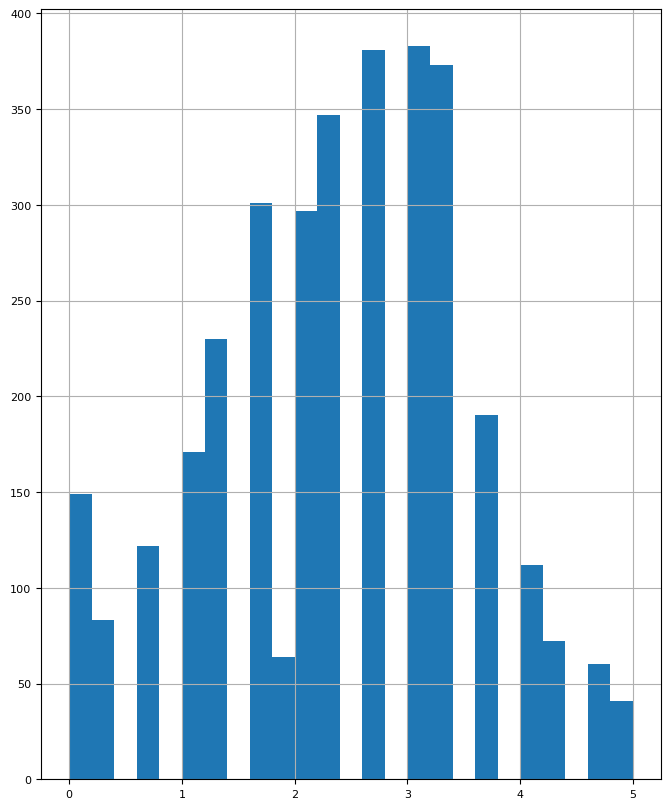

In [168]:
w5w6_st['trust_officials'].hist(figsize=(8, 10), bins=25, xlabelsize=8, ylabelsize=8);

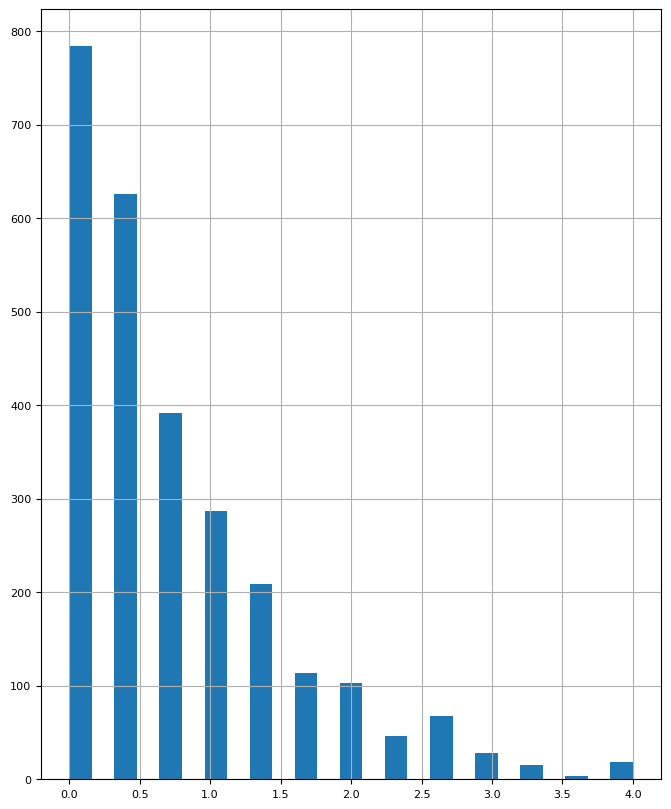

In [169]:
w5w6_st['harm_ex_weather'].hist(figsize=(8, 10), bins=25, xlabelsize=8, ylabelsize=8);

In [173]:
summarize_dataframe(w5w6_st[selected_columns].dropna()) # Only the people that have experienced an extreme weather event

,CC_variable,n_missing,n_values,complete_rate,mean,sd,p0,p25,p50,p75,p100
0,cc2,0,2695,1.0,0.652938,0.266378,0.0,0.666667,0.666667,0.666667,1.0
1,cc6,0,2695,1.0,0.608905,0.336662,0.0,0.333333,0.666667,1.000000,1.0
2,cc_behavior_meat,0,2695,1.0,0.264657,0.294670,0.0,0.000000,0.250000,0.500000,1.0
3,cc_behavior_travel,0,2695,1.0,0.262430,0.290172,0.0,0.000000,0.250000,0.500000,1.0
4,cc_policy_cars,0,2695,1.0,0.405690,0.327121,0.0,0.000000,0.500000,0.666667,1.0
5,cc_policy_re,0,2695,1.0,0.611379,0.296697,0.0,0.500000,0.666667,0.833333,1.0
6,cc_policy_house,0,2695,1.0,0.629190,0.274725,0.0,0.500000,0.666667,0.833333,1.0
7,cc_policy_risk,0,2695,1.0,0.602474,0.277980,0.0,0.500000,0.666667,0.833333,1.0
8,cc4_wealthUS,0,2695,1.0,0.373191,0.342677,0.0,0.000000,0.250000,0.750000,1.0
9,cc4_poorUS,0,2695,1.0,0.598145,0.373548,0.0,0.250000,0.750000,1.000000,1.0
